## TODO: 
FOR READERS: currently seeing which features contribute to an anomaly during trades; ultimately will start swapping brent and wti and see which one is a better feature to "create" anomalies in data

- countries that have access to it
- what political factors are affecting which one 
- area where they are 
- russia banned fuel export ban -> what is this doing to our index ? 
- r/oil keep up to date
- G7 price cap what is it 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import yfinance as yf
from sklearn.ensemble import IsolationForest
from typing import List
from prophet.plot import add_changepoints_to_plot
from prophet import Prophet
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Brent + WTI Analysis

In [2]:
# load in df
df = pd.read_excel("./data/PET_PRI_SPT_S1_D.xls", sheet_name=1)

# preprocessing
df = df.drop(df.index[:2], axis=0) # drop first two rows with uneccessary data
df.columns = ["time", "wti", "brent"] # rename columns
df = df.set_index("time") # use time series as index
df = df.dropna(axis=0) # drop nan

df

,wti,brent
time,,
1987-05-20,19.75,18.63
1987-05-21,19.95,18.45
1987-05-22,19.68,18.55
1987-05-26,19.35,18.63
1987-05-27,19.38,18.6
...,...,...
2023-09-12,88.87,93.58
2023-09-13,88.59,93.04
2023-09-14,90.13,95.2


### Observations:
1. Brent has on average lower net return but more deviation: higher deviation could mean better response to economic factors (more sensible to economic factors) 
2. Brent has lowest min -3%
3. All other features are relatively the same 

In [3]:
df.loc[:, "brent_return"] = df["brent"].pct_change() # daily percentage change brent
df.loc[:, "wti_return"] = df["wti"].pct_change() # daily percentage change brent

print(df["brent_return"].describe())
print(df["wti_return"].describe())

count    9066.000000
mean        0.000504
std         0.025286
min        -0.474654
25%        -0.011217
50%         0.000589
75%         0.012334
max         0.509868
Name: brent_return, dtype: float64
count    9066.000000
mean        0.000136
std         0.043586
min        -3.019661
25%        -0.012003
50%         0.000728
75%         0.013222
max         0.530864
Name: wti_return, dtype: float64


Observations: 
1. Brent and WTI closely follow each other, Brent is higher during 2009 - 2015 period
2. On average Brent has lower lows during dip in both indexes

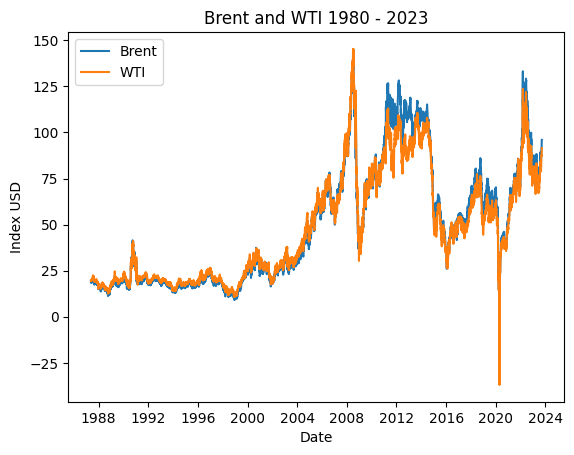

In [4]:
# plot brent and wti values                                                                                                                                                                         
plt.title("Brent and WTI 1980 - 2023")
plt.xlabel("Date")
plt.ylabel("Index USD")
plt.plot(df.index, df["brent"], label="Brent")
plt.plot(df.index, df["wti"], label="WTI")
plt.legend()
plt.show()

# Player Trading Windows and Index Fluctuations
__Observations__: 
1. Neymar, from Barcelona to PSG, is traded on the 3rd, and oil prices immediately spike in Brent index and slowly rise in WTI
2. WTI and Brent relatively follow similar growth rates 
3. Both fluctuate but WTI signals early on

## 2017 Trades - Neymar, Mbappe, Lukaku

__Notes:__
1. Both indexes have immediate jump in end of july and rise until trading date
2. Since both Neymar and Mbappe were being traded, could be possible why prices stayed high throughout August
3. Strictly looking at 4 day window described in paper, WTI responded better showing spike while Brent stayed the trading window
4. WTI responds better during Mbappe having steady increase whereas Brent stays again stable or fluctuating back and forth

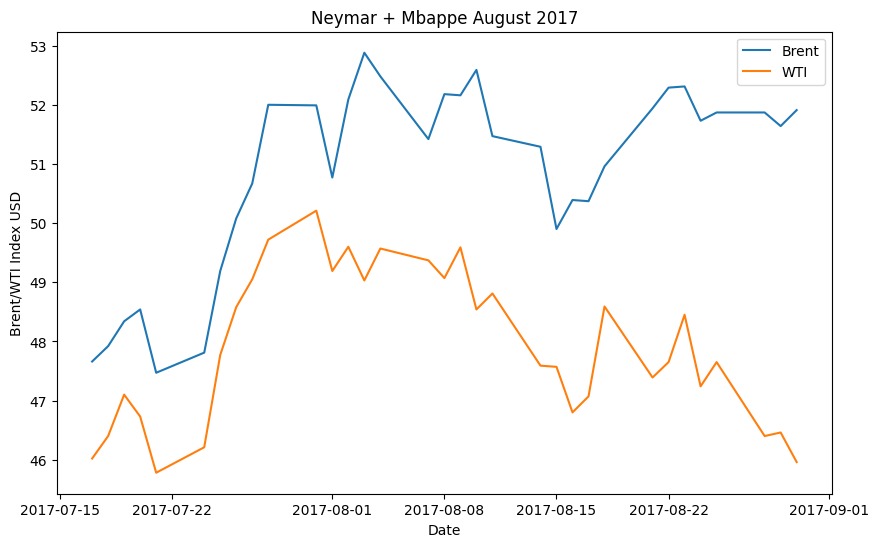

In [5]:
neymar = df.loc["2017-07-15":"2017-08-30"] # want to examine neymar trade month

# plot neymar trade window
plt.figure(figsize=(10,6))
plt.title("Neymar + Mbappe August 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(neymar.index, neymar["brent"], label="Brent")
plt.plot(neymar.index, neymar["wti"], label="WTI")
plt.legend()

### Neymar Trading Window
1. __Brent__ stayed stable whereas __WTI__ shows spike in index especially on the 3rd (day of trade)
2. __Brent__ stays relatively stable but __WTI__ starts climbing again around expected Mbappe trade window
3. __WTI__ indicates responds to trading period faster than __Brent__

__8 day Neymar Window__: Notice that Brent has higher spike **AFTER** trade is completed, however WTI has better indications of oil squeeze due to higher rate of change during pre-trade window

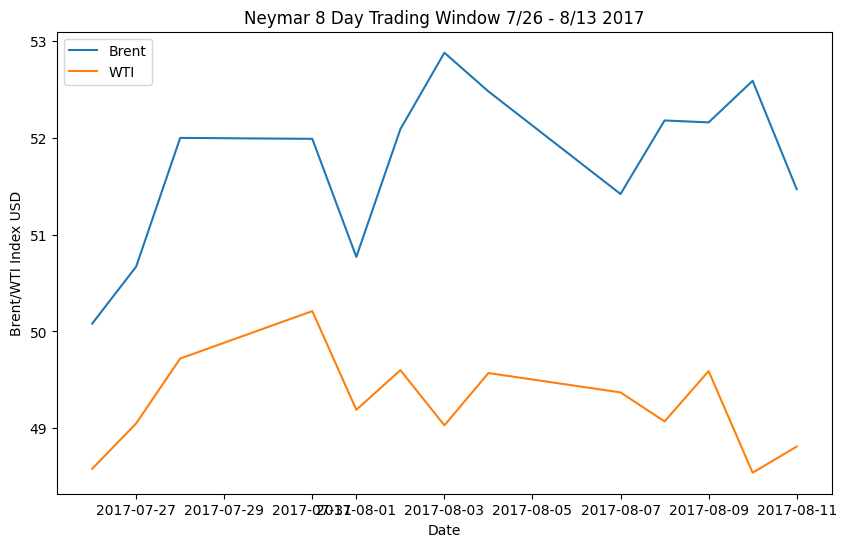

In [6]:
# indications of oil supply squeeze -> notice spike in Brent @8/2 - 3
neymar_8_day = df.loc["2017-07-26":"2017-08-13"]

plt.figure(figsize=(10,6))
plt.title("Neymar 8 Day Trading Window 7/26 - 8/13 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(neymar_8_day.index, neymar_8_day["brent"], label="Brent")
plt.plot(neymar_8_day.index, neymar_8_day["wti"], label="WTI")
plt.legend()

__Neymar 4 Day Window__: When looking at days of trade and forward, one could be mislead to believe WTI did NOT react to trade when in reality it reacted before trade occoured

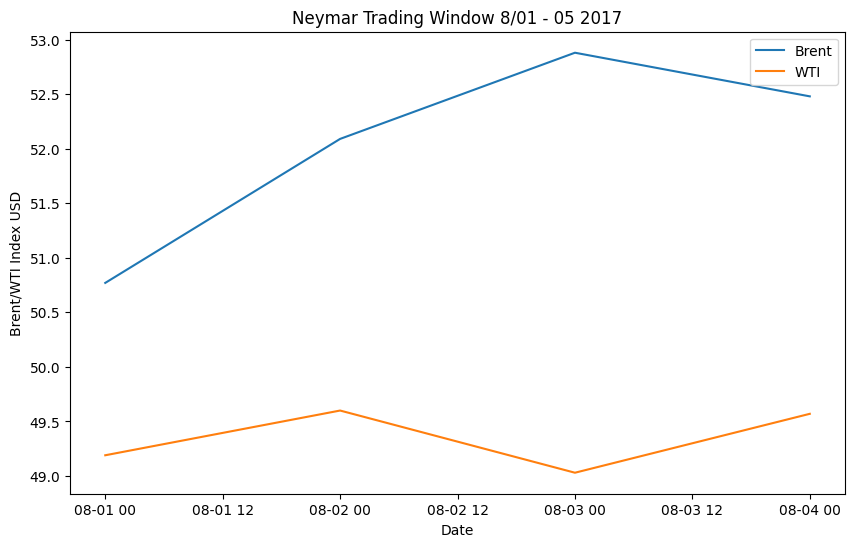

In [7]:
# "4 day window" -> August 1 to August 5
neymar_4_day = df.loc["2017-08-01":"2017-08-05"]

plt.figure(figsize=(10,6))
plt.title("Neymar Trading Window 8/01 - 05 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(neymar_4_day.index, neymar_4_day["brent"], label="Brent")
plt.plot(neymar_4_day.index, neymar_4_day["wti"], label="WTI")
plt.legend()

### Mbappe Trading Window
__Notes__: 
1. WTI has more darastic rate of change, better for signaling upcoming trade
2. Both Brent and WTI continue to grow after trade, follow similar trends
3. Ultimately WTI is more sensitive to factors in economy (assuming it spiked due to oil squeeze)

__Mbappe 8 Day Window__: WTI is fluctuates more prior to trade

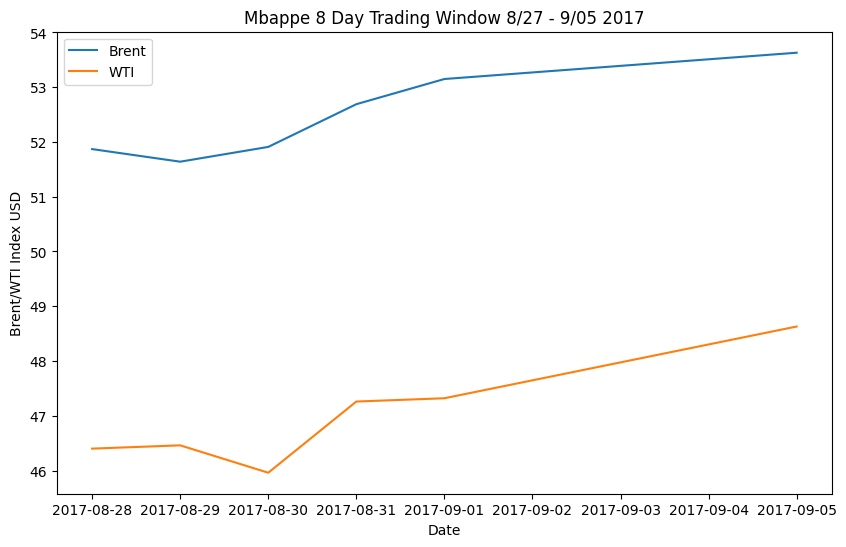

In [8]:
# WTI responds faster, in this case Brent has dip during expected squeeze day but WTI starts rising
mbappe_8_day = df.loc["2017-08-27":"2017-09-05"]

plt.figure(figsize=(10,6))
plt.title("Mbappe 8 Day Trading Window 8/27 - 9/05 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(mbappe_8_day.index, mbappe_8_day["brent"], label="Brent")
plt.plot(mbappe_8_day.index, mbappe_8_day["wti"], label="WTI")
plt.legend()

__Mbappe 4 Day Window__: Rate of change from 30 to 31 is more darastic in WTI

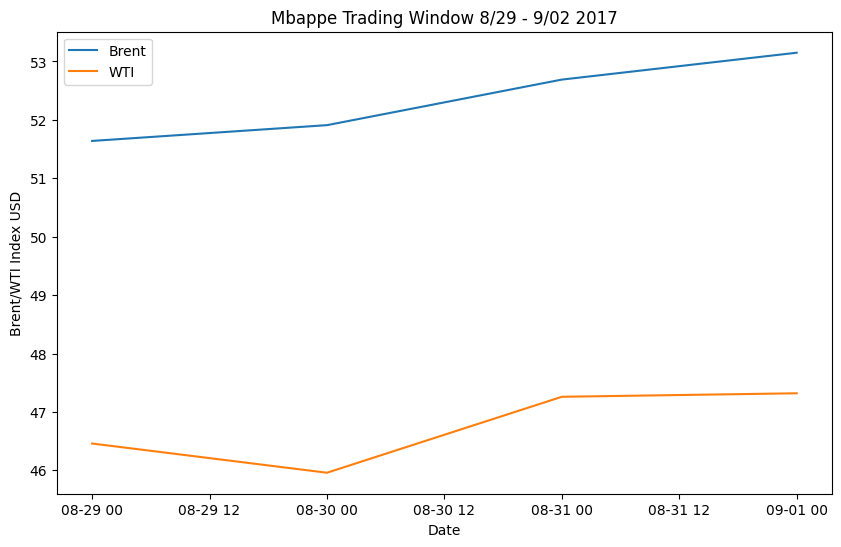

In [9]:
# "4 day window" -> August 29 to September 2
mbappe_4_day = df.loc["2017-08-29":"2017-09-02"]

plt.figure(figsize=(10,6))
plt.title("Mbappe Trading Window 8/29 - 9/02 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(mbappe_4_day.index, mbappe_4_day["brent"], label="Brent")
plt.plot(mbappe_4_day.index, mbappe_4_day["wti"], label="WTI")
plt.legend()

### Lukaku Trading Window
__Note__: 
1. Both WTI and Brent index started increasing prior to trade date (7/10)
2. Both index come back from dip on 7/7 and follow similar trend
3. Assuming squeeze happened, WTI responded faster to oil squeeze by starting spike on 7/10 (trade date) vs Brent on 7/12

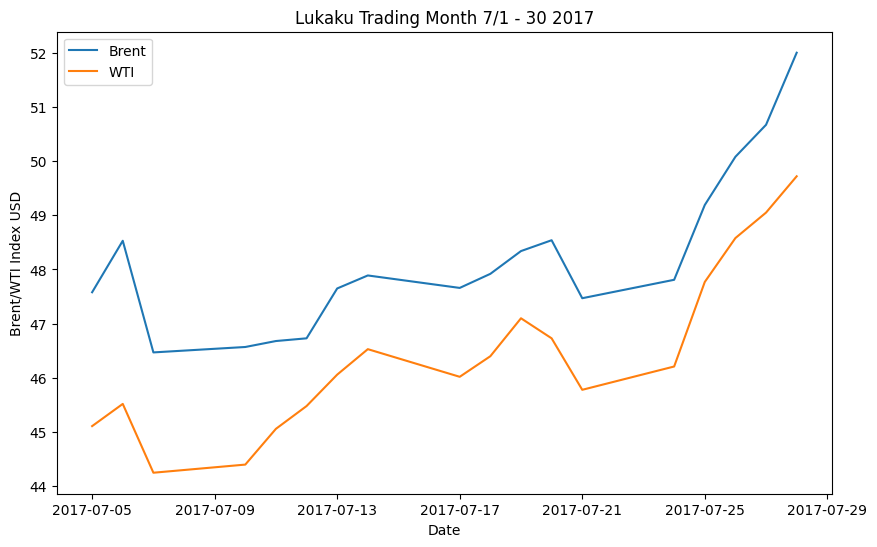

In [10]:
# july 2017, lukaku trading month
lukaku = df.loc["2017-07-01":"2017-07-30"]

plt.figure(figsize=(10,6))
plt.title("Lukaku Trading Month 7/1 - 30 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(lukaku.index, lukaku["brent"], label="Brent")
plt.plot(lukaku.index, lukaku["wti"], label="WTI")
plt.legend()

__Lukaku 8 Day Window__: Both index start flat lining around 7/7 and WTI responds to trade on trade day and starts rising, Brent responds 2 days late

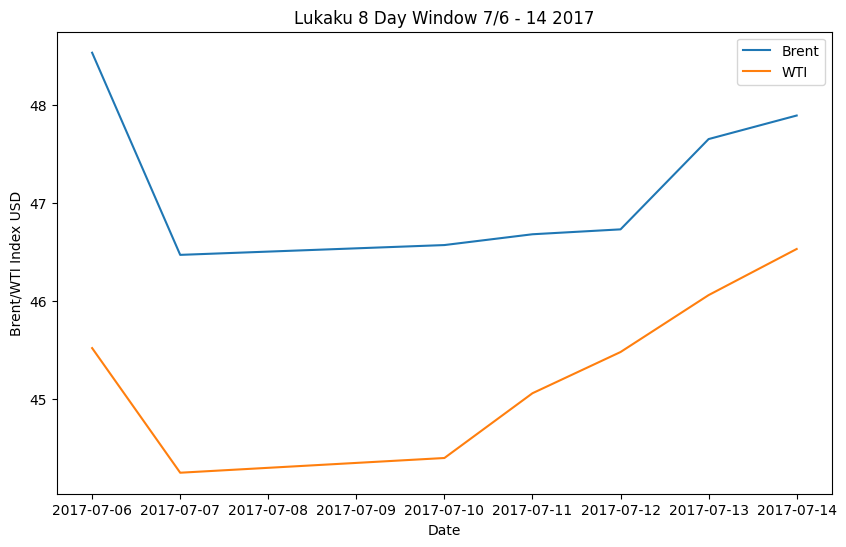

In [11]:
lukaku_8_day = df.loc["2017-07-06":"2017-07-14"]

plt.figure(figsize=(10,6))
plt.title("Lukaku 8 Day Window 7/6 - 14 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(lukaku_8_day.index, lukaku_8_day["brent"], label="Brent")
plt.plot(lukaku_8_day.index, lukaku_8_day["wti"], label="WTI")
plt.legend()

__Lukaku 4 Day Window__: Can notice WTI responds to squeeze

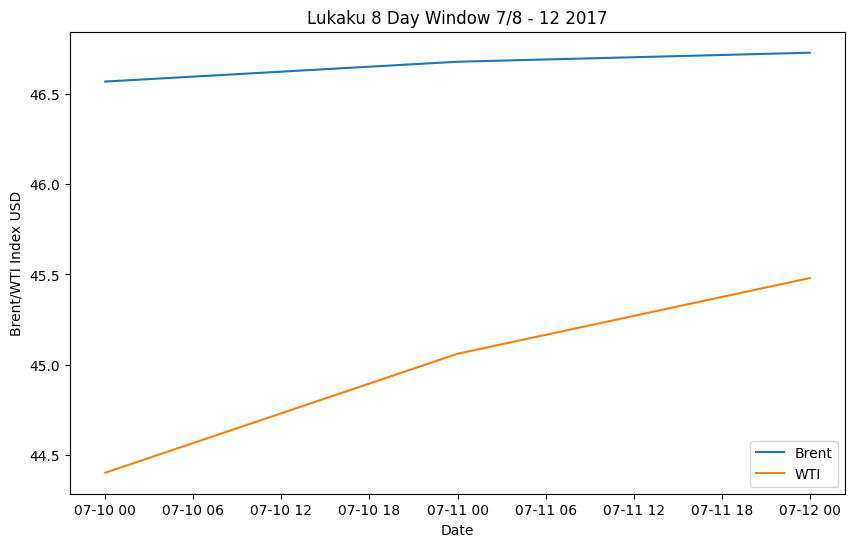

In [12]:
lukaku_4_day = df.loc["2017-07-08":"2017-07-12"]

plt.figure(figsize=(10,6))
plt.title("Lukaku 8 Day Window 7/8 - 12 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(lukaku_4_day.index, lukaku_4_day["brent"], label="Brent")
plt.plot(lukaku_4_day.index, lukaku_4_day["wti"], label="WTI")
plt.legend()

__Note__: Both indexes closely follow each other, however, WTI seems to be more senstive to trades by responding earlier or on the day of to an oil squeeze. Must test WTI and Brent in conjunction with other features (which features are important?) in order to understand which index is better at signaling oil squeezes and future trades

## Data Analysis

__Note__: DJI and SP500 used later for data analysis

In [13]:
sp500 = yf.download("^GSPC", df.index[0], df.index[-1]) # ^GSPC ticker for SP500
dji = yf.download("^DJI", df.index[0], df.index[-1])  # dji data

# save to df
df["sp500"] = sp500["Close"]
df["dji"] = dji["Close"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [14]:
df

,wti,brent,brent_return,wti_return,sp500,dji
time,,,,,,
1987-05-20,19.75,18.63,NaN,NaN,278.209991,NaN
1987-05-21,19.95,18.45,-0.009662,0.010127,280.170013,NaN
1987-05-22,19.68,18.55,0.005420,-0.013534,282.160004,NaN
1987-05-26,19.35,18.63,0.004313,-0.016768,289.109985,NaN
1987-05-27,19.38,18.6,-0.001610,0.001550,288.730011,NaN
...,...,...,...,...,...,...
2023-09-12,88.87,93.58,0.017506,0.017984,4461.899902,34645.988281
2023-09-13,88.59,93.04,-0.005770,-0.003151,4467.439941,34575.531250
2023-09-14,90.13,95.2,0.023216,0.017383,4505.100098,34907.109375


### Questions:
1. Does Brent future closely follow spot? A: Yes
2. Are futures more sensitive to player trades? (on trading window, before and after) A: No, Brent future and spot closely follow each other
3. What features can be developed from these two?

In [15]:
# preprocessing
futures = pd.read_csv("/Users/visheshnarayan/Documents/Code/UMDClubs/Apex/data/brent_futures.csv") # read in brent future data
futures = pd.concat([pd.read_csv("/Users/visheshnarayan/Documents/Code/UMDClubs/Apex/data/brent_futures_2.csv"), futures], axis=0) # concat with other features
futures = futures.dropna() # drop missing values

futures["Date"] = futures["Date"].apply(lambda date: datetime.strptime(date[6:]+"-"+date[0:2]+"-"+date[3:5], "%Y-%m-%d")) # convert dates from str to datetime
futures["Vol."] = futures["Vol."].apply(lambda string: float(string.replace("K", ""))*1000) # values in thousands -> multiply by 1000
futures["volume_log"] = futures["Vol."].apply(lambda volume: np.log(volume)) # logarithmic volume, smoothen data
futures["Change %"] = futures["Change %"].apply(lambda string: float(string.replace("%", ""))/100) # percentage value -> divide by 100
futures["volume_change"] = futures["Vol."].pct_change() # calculate change in volume day to day
futures["price_log"] = np.log(futures["Price"]) # logarithmic price, smoothen data
futures["difference"] = futures["Price"].diff() # day to day difference in price

futures = futures.set_index("Date") # set date as index
futures = futures.sort_values(by='Date', ascending=True) # sort ascending

futures["3_MA"] = futures["Price"].rolling(window = 3).mean() # moving average for 3 days
futures["6_MA"] = futures["Price"].rolling(window = 6).mean() # moving average for 3 days
futures["10_MA"] = futures["Price"].rolling(window=10).mean() # moving average for 3 days
futures["365_MA"] = futures["Price"].rolling(window = 365).mean() # yearly MA

futures = futures.dropna() # drop empty values
futures["date"] = futures.index # create column for dates 

futures

,Price,Open,High,Low,Vol.,Change %,volume_log,volume_change,price_log,difference,3_MA,6_MA,10_MA,365_MA,date
Date,,,,,,,,,,,,,,,
1989-12-01,18.66,18.54,18.70,18.50,3900.0,0.0092,8.268732,-0.498715,2.926382,-0.50,18.410000,18.400000,18.447,16.253397,1989-12-01
1989-12-04,19.16,19.05,19.29,19.00,7780.0,0.0268,8.959312,0.634454,2.952825,0.12,18.770000,18.520000,18.500,16.264521,1989-12-04
1989-12-05,19.04,19.05,19.26,19.03,4760.0,-0.0063,8.468003,-0.096774,2.946542,-0.11,18.953333,18.620000,18.546,16.274849,1989-12-05
1989-12-06,19.15,19.00,19.20,18.97,5270.0,0.0058,8.569786,-0.209895,2.952303,-0.10,19.116667,18.763333,18.610,16.286630,1989-12-06
1989-12-07,19.25,19.22,19.41,19.22,6670.0,0.0052,8.805375,0.973373,2.957511,0.13,19.146667,18.958333,18.700,16.299370,1989-12-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11,90.64,90.83,91.45,90.11,303420.0,-0.0001,12.622873,-0.098494,4.506896,-1.42,90.403333,90.141667,88.761,90.270247,2023-09-11
2023-09-12,92.06,90.62,92.40,90.52,336570.0,0.0157,12.726561,0.111709,4.522441,0.18,91.116667,90.651667,89.418,90.235781,2023-09-12
2023-09-13,91.88,92.04,92.84,91.63,302750.0,-0.0020,12.620663,-0.023387,4.520483,-1.82,91.526667,90.958333,90.020,90.189479,2023-09-13


### Reanalyze Player Trade Windows
1. Neymar
2. Mbappe
3. Lukaku

__Notice__ that futures reacts slower: the futures price will start going up AFTER the normal spot, interesting for investing since that indicates we should hold on to future a little longer for more profit

#### Neymar window
1. WTI is valued relatively less than Brent but both follow same trends
2. Moving Averages give delayed signal of oil squeeze/player trade (there are no prior signals of squeeze happening other than fluctuations, which would only show up later in MA)
3. Brent Future follows price of Brent with delay

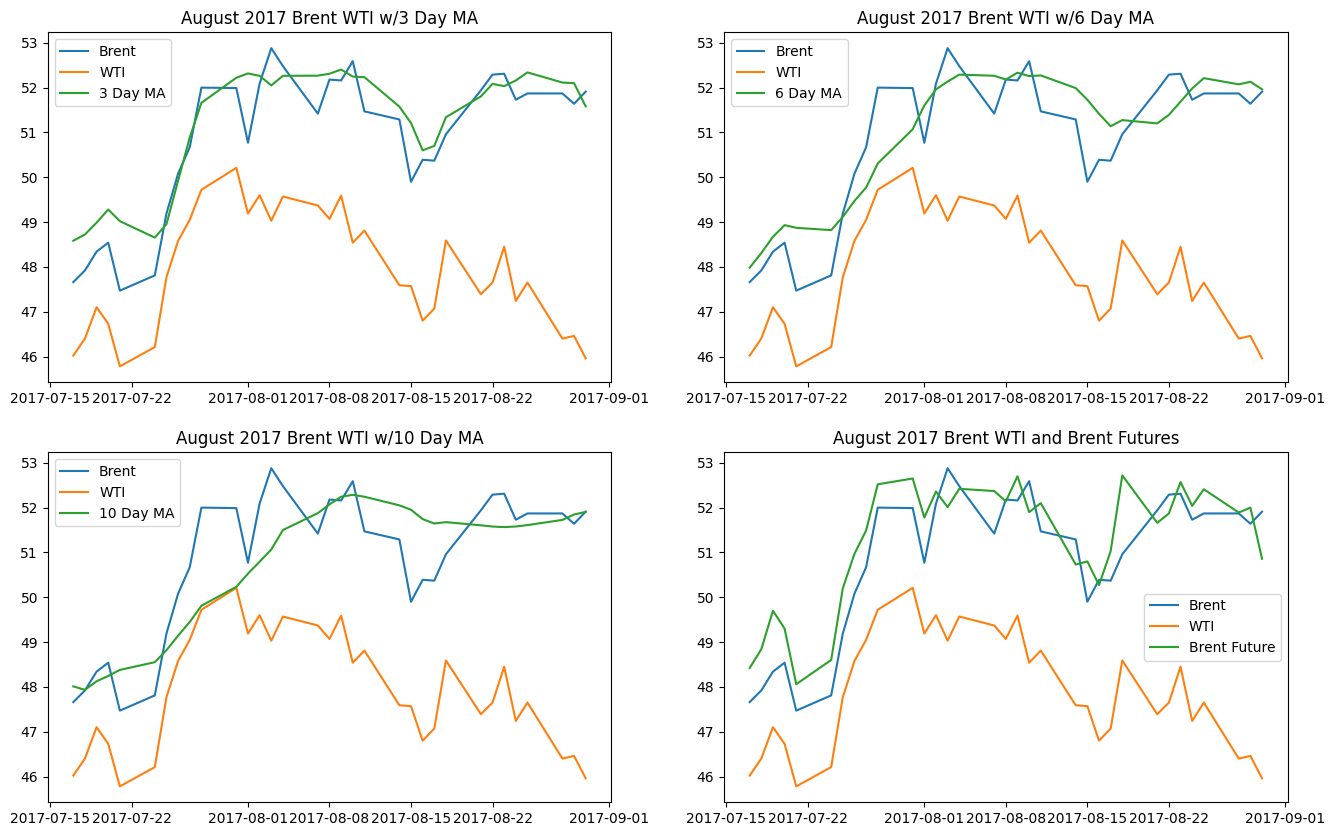

In [16]:
neymar_futures = futures["2017-07-15":"2017-08-30"]

# create subplots for seperate moving averages + futures
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# 0, 0 -> brent, wti, 3 day ma
axs[0, 0].plot(neymar.index, neymar["brent"], label="Brent")
axs[0, 0].plot(neymar.index, neymar["wti"], label="WTI")
axs[0, 0].plot(neymar_futures.index, neymar_futures["3_MA"], label="3 Day MA")
axs[0, 0].legend()
axs[0, 0].set_title("August 2017 Brent WTI w/3 Day MA")

# 0, 1 -> brent, wti, 6 day ma
axs[0, 1].plot(neymar.index, neymar["brent"], label="Brent")
axs[0, 1].plot(neymar.index, neymar["wti"], label="WTI")
axs[0, 1].plot(neymar_futures.index, neymar_futures["6_MA"], label="6 Day MA")
axs[0, 1].legend()
axs[0, 1].set_title("August 2017 Brent WTI w/6 Day MA")

# 1, 0 -> brent, wti, 10 day ma
axs[1, 0].plot(neymar.index, neymar["brent"], label="Brent")
axs[1, 0].plot(neymar.index, neymar["wti"], label="WTI")
axs[1, 0].plot(neymar_futures.index, neymar_futures["10_MA"], label="10 Day MA")
axs[1, 0].legend()
axs[1, 0].set_title("August 2017 Brent WTI w/10 Day MA")

# 1, 1 -> brent, wti, brent future
axs[1, 1].plot(neymar.index, neymar["brent"], label="Brent")
axs[1, 1].plot(neymar.index, neymar["wti"], label="WTI")
axs[1, 1].plot(neymar_futures.index, neymar_futures["Price"], label="Brent Future")
axs[1, 1].legend()
axs[1, 1].set_title("August 2017 Brent WTI and Brent Futures")

plt.show()

__Neymar 8 Day Window__: WTI having earlier fluctuations stays true, Brent Futures follow trends of Brent with slight delay

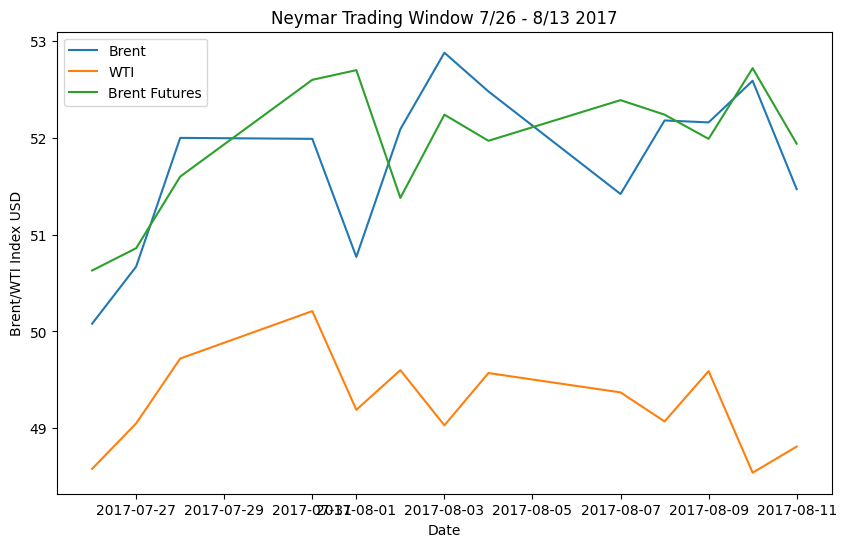

In [17]:
# zoomed out window -> July 26 to August 13
neymar_zoomed_out = futures["2017-07-26":"2017-08-13"]

# create fig
plt.figure(figsize=(10,6))
plt.title("Neymar Trading Window 7/26 - 8/13 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(neymar_8_day.index, neymar_8_day["brent"], label="Brent")
plt.plot(neymar_8_day.index, neymar_8_day["wti"], label="WTI")
plt.plot(neymar_zoomed_out.index, neymar_zoomed_out["Open"], label="Brent Futures")
plt.legend()

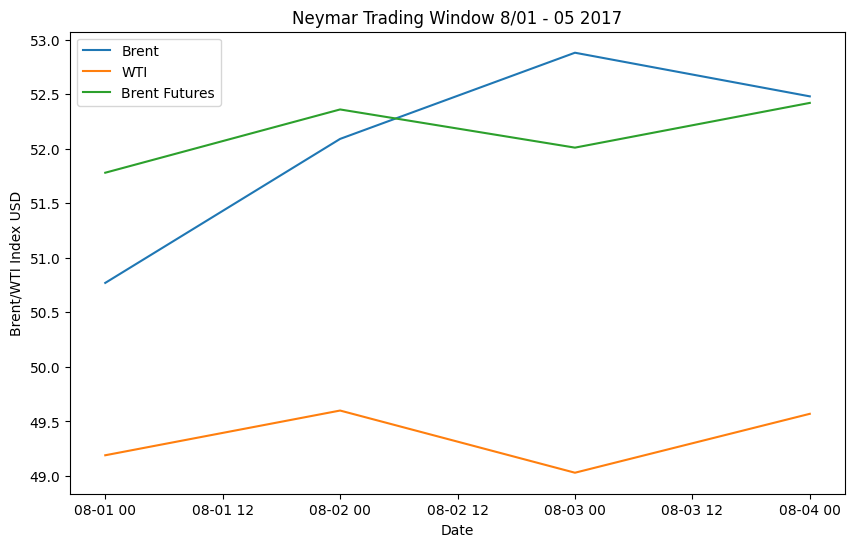

In [18]:
# 4 day window -> August 1 to August 5
neymar_4_day_futures = futures["2017-08-01":"2017-08-05"]

# create fig
plt.figure(figsize=(10,6))
plt.title("Neymar Trading Window 8/01 - 05 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(neymar_4_day.index, neymar_4_day["brent"], label="Brent") # plot brent
plt.plot(neymar_4_day.index, neymar_4_day["wti"], label="WTI") # plot wti
plt.plot(neymar_4_day_futures.index, neymar_4_day_futures["Price"], label="Brent Futures") # plot futures
plt.legend()

#### Mbappe Window

__Mbappe 8 Day Window__: WTI and Brent Future fluctuate in similar fashion, Brent spot is less sensitive to trade happening

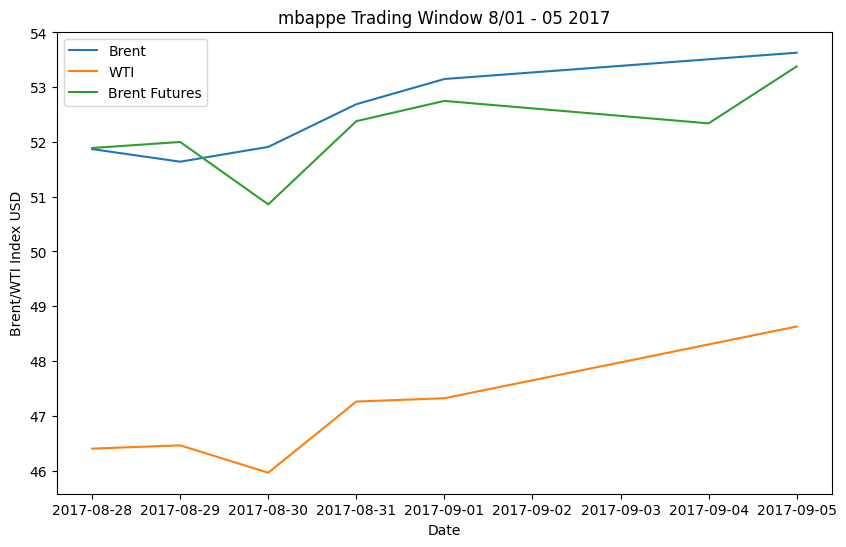

In [19]:
# Mbappe 8 day window -> 8/28 - 9/5
mbappe_4_day_futures = futures["2017-08-28":"2017-09-05"]

# create fig
plt.figure(figsize=(10,6))
plt.title("mbappe Trading Window 8/01 - 05 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(mbappe_8_day.index, mbappe_8_day["brent"], label="Brent") # plot brent
plt.plot(mbappe_8_day.index, mbappe_8_day["wti"], label="WTI") # plot wti
plt.plot(mbappe_4_day_futures.index, mbappe_4_day_futures["Price"], label="Brent Futures") # plot futures
plt.legend()

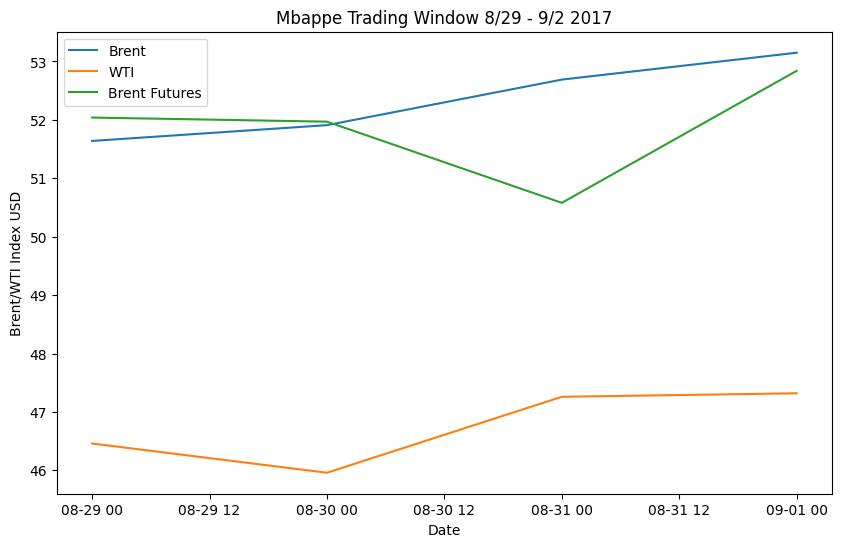

In [20]:
# mbappe trading window
mbappe_4_day_futures = futures.loc["2017-08-29":"2017-09-02"]

# create fig
plt.figure(figsize=(10,6))
plt.title("Mbappe Trading Window 8/29 - 9/2 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(mbappe_4_day.index, mbappe_4_day["brent"], label="Brent")
plt.plot(mbappe_4_day.index, mbappe_4_day["wti"], label="WTI")
plt.plot(mbappe_4_day_futures.index, mbappe_4_day_futures["Open"], label="Brent Futures")
plt.legend()

## EDA

In [21]:
futures

,Price,Open,High,Low,Vol.,Change %,volume_log,volume_change,price_log,difference,3_MA,6_MA,10_MA,365_MA,date
Date,,,,,,,,,,,,,,,
1989-12-01,18.66,18.54,18.70,18.50,3900.0,0.0092,8.268732,-0.498715,2.926382,-0.50,18.410000,18.400000,18.447,16.253397,1989-12-01
1989-12-04,19.16,19.05,19.29,19.00,7780.0,0.0268,8.959312,0.634454,2.952825,0.12,18.770000,18.520000,18.500,16.264521,1989-12-04
1989-12-05,19.04,19.05,19.26,19.03,4760.0,-0.0063,8.468003,-0.096774,2.946542,-0.11,18.953333,18.620000,18.546,16.274849,1989-12-05
1989-12-06,19.15,19.00,19.20,18.97,5270.0,0.0058,8.569786,-0.209895,2.952303,-0.10,19.116667,18.763333,18.610,16.286630,1989-12-06
1989-12-07,19.25,19.22,19.41,19.22,6670.0,0.0052,8.805375,0.973373,2.957511,0.13,19.146667,18.958333,18.700,16.299370,1989-12-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11,90.64,90.83,91.45,90.11,303420.0,-0.0001,12.622873,-0.098494,4.506896,-1.42,90.403333,90.141667,88.761,90.270247,2023-09-11
2023-09-12,92.06,90.62,92.40,90.52,336570.0,0.0157,12.726561,0.111709,4.522441,0.18,91.116667,90.651667,89.418,90.235781,2023-09-12
2023-09-13,91.88,92.04,92.84,91.63,302750.0,-0.0020,12.620663,-0.023387,4.520483,-1.82,91.526667,90.958333,90.020,90.189479,2023-09-13


In [22]:
df.describe()

,brent_return,wti_return,sp500,dji
count,9066.000000,9066.000000,9036.000000,7876.000000
mean,0.000504,0.000136,1465.697936,14049.781843
std,0.025286,0.043586,1070.366572,8546.763050
min,-0.474654,-3.019661,223.919998,3136.600098
25%,-0.011217,-0.012003,656.014999,8743.782715
50%,0.000589,0.000728,1211.744995,11024.504883
75%,0.012334,0.013222,1927.302490,17732.060059
max,0.509868,0.530864,4796.560059,36799.648438


In [23]:
futures.describe()

,Price,Open,High,Low,Vol.,Change %,volume_log,volume_change,price_log,difference,3_MA,6_MA,10_MA,365_MA
count,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000
mean,52.272747,52.270876,52.991879,51.519260,113717.284208,0.000453,11.044197,0.277766,3.733977,-0.008779,52.264000,52.251122,52.234274,50.857915
std,32.894150,32.880345,33.282213,32.452352,110751.484051,0.022997,1.194725,7.438584,0.692166,1.257411,32.882602,32.869669,32.853689,31.269606
min,9.640000,9.700000,9.950000,9.550000,100.000000,-0.347700,4.605170,-0.998703,2.265921,-10.150000,9.813333,9.985000,10.063000,13.342301
25%,20.500000,20.485000,20.725000,20.295000,23235.000000,-0.010400,10.053415,-0.153409,3.020425,-0.490000,20.463333,20.463333,20.463500,20.275096
50%,47.880000,47.900000,48.790000,46.960000,59490.000000,0.000900,10.993564,0.031288,3.868698,-0.030000,47.973333,47.945000,47.926000,48.742247
75%,75.080000,75.110000,76.115000,74.065000,197975.000000,0.011500,12.195896,0.254448,4.318554,0.430000,75.018333,75.025000,75.056500,72.368041
max,146.080000,146.300000,147.500000,144.250000,779720.000000,0.210200,13.566690,682.116279,4.984154,16.840000,144.920000,142.855000,142.075000,112.800219


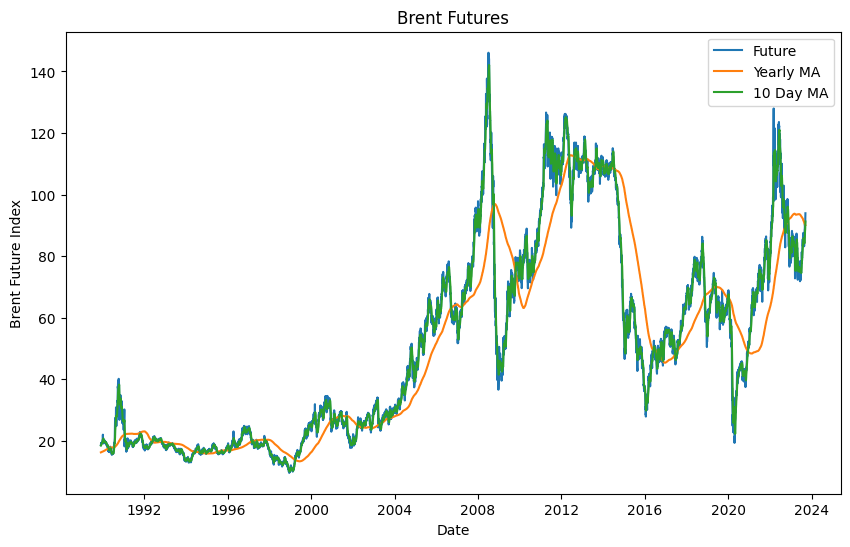

In [24]:
# plot brent future
plt.figure(figsize=(10,6))
plt.title("Brent Futures")
plt.xlabel("Date")
plt.ylabel("Brent Future Index")
plt.plot(futures.index, futures["Price"], label="Future") # spot
plt.plot(futures.index, futures["365_MA"], label="Yearly MA") # yearly ma
plt.plot(futures.index, futures["10_MA"], label="10 Day MA") # 10 day ma
plt.legend()

__Note__:
1. Correlation between volume and prices, can other factors be incorporated into a regression? 
2. All correlation makes sense: open, close, price all correlate and volume correlates with increase in price

/var/folders/p6/9c98fqb51038xhz870chsj280000gn/T/ipykernel_9108/1690242451.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = futures.corr()


<Axes: >

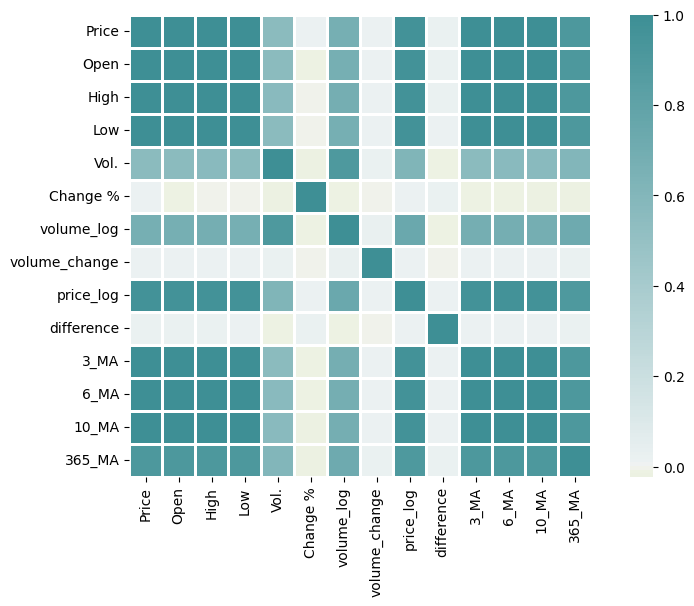

In [25]:
# use correlation matrix to indicate independence of vars
corr = futures.corr()

# plot
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(100, 200, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(corr,
            cmap=cmap,
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 1.0})

/var/folders/p6/9c98fqb51038xhz870chsj280000gn/T/ipykernel_9108/3187464423.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

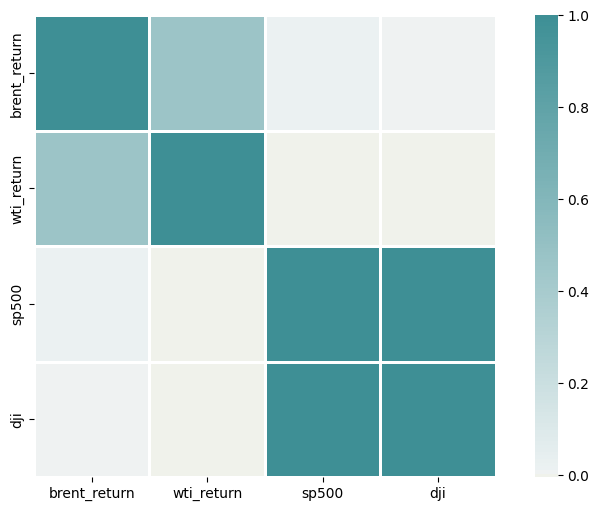

In [26]:
corr = df.corr()

# plot
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr,
            cmap=cmap,
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 1.0})

__Note__: Volume is interesting to examine due to its relationship with futures price; STD of 1.19 is high considering the data is logarithmic so volume can indicate shifts in oil supply

In [27]:
# describe volume change stats
futures["volume_change"].describe()

count    8631.000000
mean        0.277766
std         7.438584
min        -0.998703
25%        -0.153409
50%         0.031288
75%         0.254448
max       682.116279
Name: volume_change, dtype: float64

In [28]:
futures["volume_log"].describe()

count    8631.000000
mean       11.044197
std         1.194725
min         4.605170
25%        10.053415
50%        10.993564
75%        12.195896
max        13.566690
Name: volume_log, dtype: float64

## Volume Change % vs. Index Change %
__Notes__:
1. Definite spike in volume change during player trades
2. Brent Futures and WTI follow each other almost identically during these periods
3. Volume change is an important factor
4. __IMPORTANT__: Index changes right before change volume spike

### Neymar 8 Day Window

High spike in volume day before trade

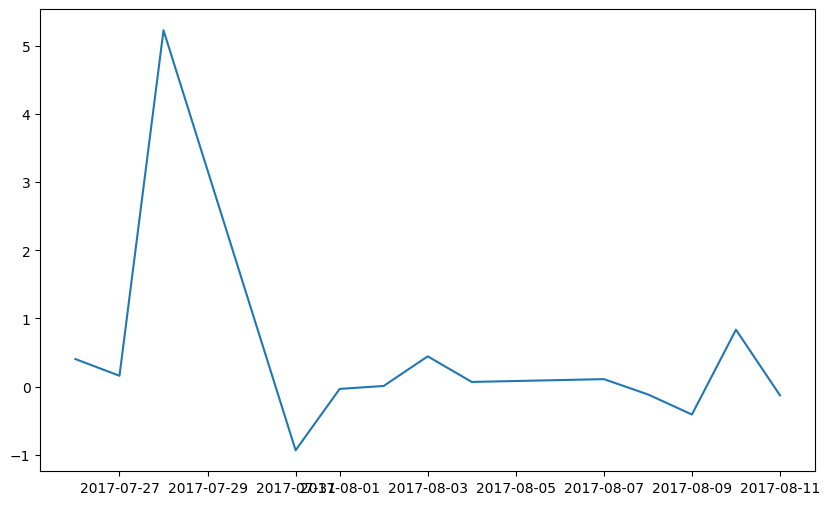

In [29]:
plt.figure(figsize=(10,6))
plt.plot(neymar_8_day.index, futures.loc["2017-07-26":"2017-08-13"]["volume_change"])

Value of WTI and Brent both drop shortly after volume spike

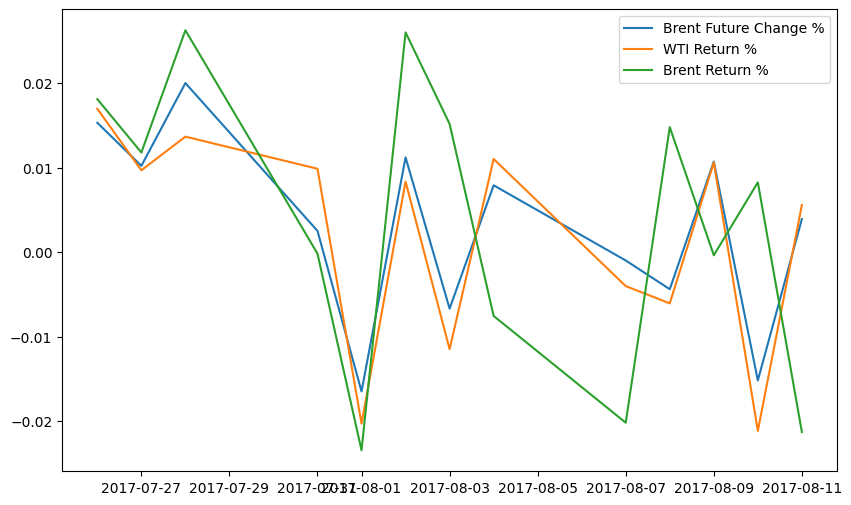

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(neymar_8_day.index, futures.loc["2017-07-26":"2017-08-13"]["Change %"], label="Brent Future Change %")
plt.plot(neymar_8_day.index, df.loc["2017-07-26":"2017-08-13"]["wti_return"], label="WTI Return %")
plt.plot(neymar_8_day.index, neymar_8_day["brent_return"], label="Brent Return %")
plt.legend()

### Mbappe 8 Day Window 

High spike similar to Neymar

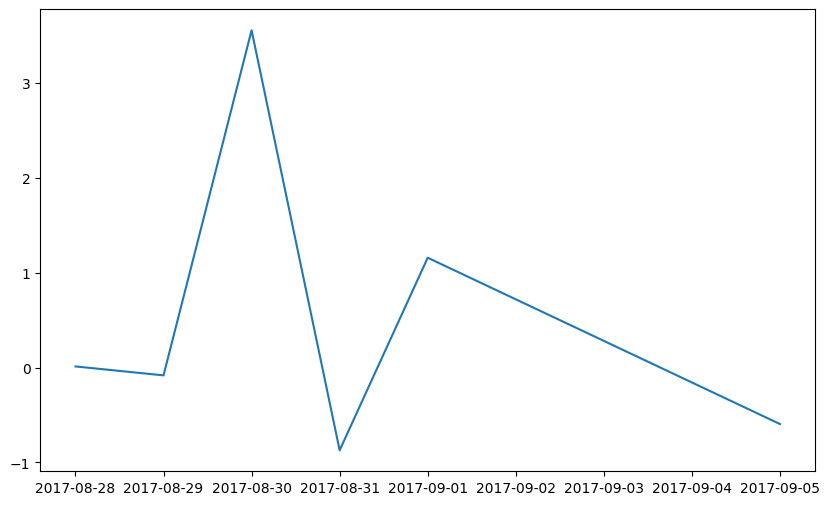

In [31]:
plt.figure(figsize=(10,6))
plt.plot(mbappe_8_day.index, futures.loc["2017-08-28":"2017-09-04"]["volume_change"])

Drop in value similar to Neymar

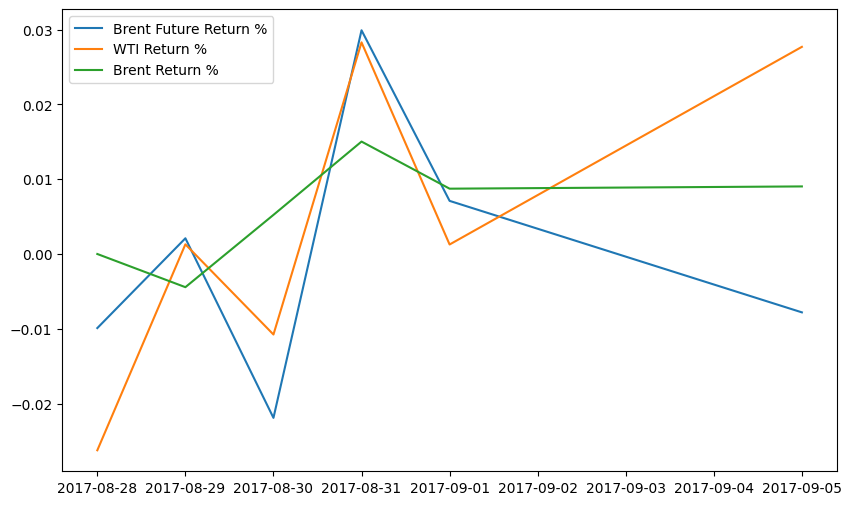

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(mbappe_8_day.index, futures.loc["2017-08-28":"2017-09-04"]["Change %"], label="Brent Future Return %")
plt.plot(mbappe_8_day.index, df.loc["2017-08-28":"2017-09-05"]["wti_return"], label="WTI Return %")
plt.plot(mbappe_8_day.index, mbappe_8_day["brent_return"], label="Brent Return %")
plt.legend()

Models/Methods to check:
1. Isolation Tree 
2. One Class SVM
3. Autoencoders -> reconstruction will have errors, anomoly 
4. Anomoly detection with PCA? 

# Anomoly Detection

## Brent Feature Analysis

### Isolation Tree
Notes: 
1. Able to detect anomolies 
2. Accurate when only looking at singular volume value, what if we include other factors? 
3. What generates accurate anomolies: WTI or Brent? 

In [33]:
futures

,Price,Open,High,Low,Vol.,Change %,volume_log,volume_change,price_log,difference,3_MA,6_MA,10_MA,365_MA,date
Date,,,,,,,,,,,,,,,
1989-12-01,18.66,18.54,18.70,18.50,3900.0,0.0092,8.268732,-0.498715,2.926382,-0.50,18.410000,18.400000,18.447,16.253397,1989-12-01
1989-12-04,19.16,19.05,19.29,19.00,7780.0,0.0268,8.959312,0.634454,2.952825,0.12,18.770000,18.520000,18.500,16.264521,1989-12-04
1989-12-05,19.04,19.05,19.26,19.03,4760.0,-0.0063,8.468003,-0.096774,2.946542,-0.11,18.953333,18.620000,18.546,16.274849,1989-12-05
1989-12-06,19.15,19.00,19.20,18.97,5270.0,0.0058,8.569786,-0.209895,2.952303,-0.10,19.116667,18.763333,18.610,16.286630,1989-12-06
1989-12-07,19.25,19.22,19.41,19.22,6670.0,0.0052,8.805375,0.973373,2.957511,0.13,19.146667,18.958333,18.700,16.299370,1989-12-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11,90.64,90.83,91.45,90.11,303420.0,-0.0001,12.622873,-0.098494,4.506896,-1.42,90.403333,90.141667,88.761,90.270247,2023-09-11
2023-09-12,92.06,90.62,92.40,90.52,336570.0,0.0157,12.726561,0.111709,4.522441,0.18,91.116667,90.651667,89.418,90.235781,2023-09-12
2023-09-13,91.88,92.04,92.84,91.63,302750.0,-0.0020,12.620663,-0.023387,4.520483,-1.82,91.526667,90.958333,90.020,90.189479,2023-09-13


In [34]:
features = ["price_log", "volume_change", "difference"] # features to analyze
print(f"input feature array:\n\n{np.array(futures.loc['2017-07-26':'2017-08-13', features]).reshape(-1, 3)}") # example input array

input feature array:

[[ 3.93123722  0.40405574 -0.52      ]
 [ 3.94138761  0.15884386 -1.03      ]
 [ 3.96119405  5.23140172 -0.13      ]
 [ 3.96366624 -0.93495314  0.87      ]
 [ 3.94700397 -0.03390581 -0.58      ]
 [ 3.95814294  0.0093379   0.35      ]
 [ 3.95143601  0.44436473 -0.41      ]
 [ 3.9592882   0.06836821  0.05      ]
 [ 3.95833391  0.10962749  0.23      ]
 [ 3.95393241 -0.11464177 -0.56      ]
 [ 3.96461546 -0.41012259  0.8       ]
 [ 3.94931879  0.83555501 -0.2       ]
 [ 3.95316495 -0.12877792  1.37      ]]


### Neymar Trading w/Brent fitting

### Methods for Anomoly Testing

In [35]:
def create_input(rows: pd.DataFrame, n_features: int) -> np.ndarray:
    '''
    Return stacked rows with n_features columns

    rows: specified rows to create input for
    n_features: number of features
    '''
    return np.array(rows).reshape(-1, n_features)

def print_anomalies(results: np.ndarray, start: str, end: str) -> None:
    '''
    Prints results of anomoly test, 1 if normal & -1 if anomoly
    
    results: numpy array of results
    start: string of start date
    end: string of end date
    '''
    dates = futures["date"][start:end] # get range of dates

    # for each date -> print result
    for i in range(len(dates)):
        print(f"{dates[i]} :: {results[i]}")

def anomaly_test(features: List[str], start: str, end: str) -> np.ndarray:
    '''
    Runs anomoly test on given given date range with given features

    features: list of columns (strings) for features to test anomoly open
    start: string of starting date
    end: string of end date
    '''
    X_test = create_input(futures.loc[start:end, features], len(features)) # create input array
    results = clf.predict(X_test) # get predicitions
    print_anomalies(results, start, end) # print predicitions
    return results

X = create_input(futures.loc[:, features], 3)
clf = IsolationForest(random_state=0, contamination=0.3).fit(X)

__Note__: Detected anomoly on trade day and day before for NEYMAR

In [36]:
results = anomaly_test(start="2017-07-26", end="2017-08-13", features=features)

2017-07-26 00:00:00 :: 1
2017-07-27 00:00:00 :: 1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: 1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: -1
2017-08-10 00:00:00 :: 1
2017-08-11 00:00:00 :: 1


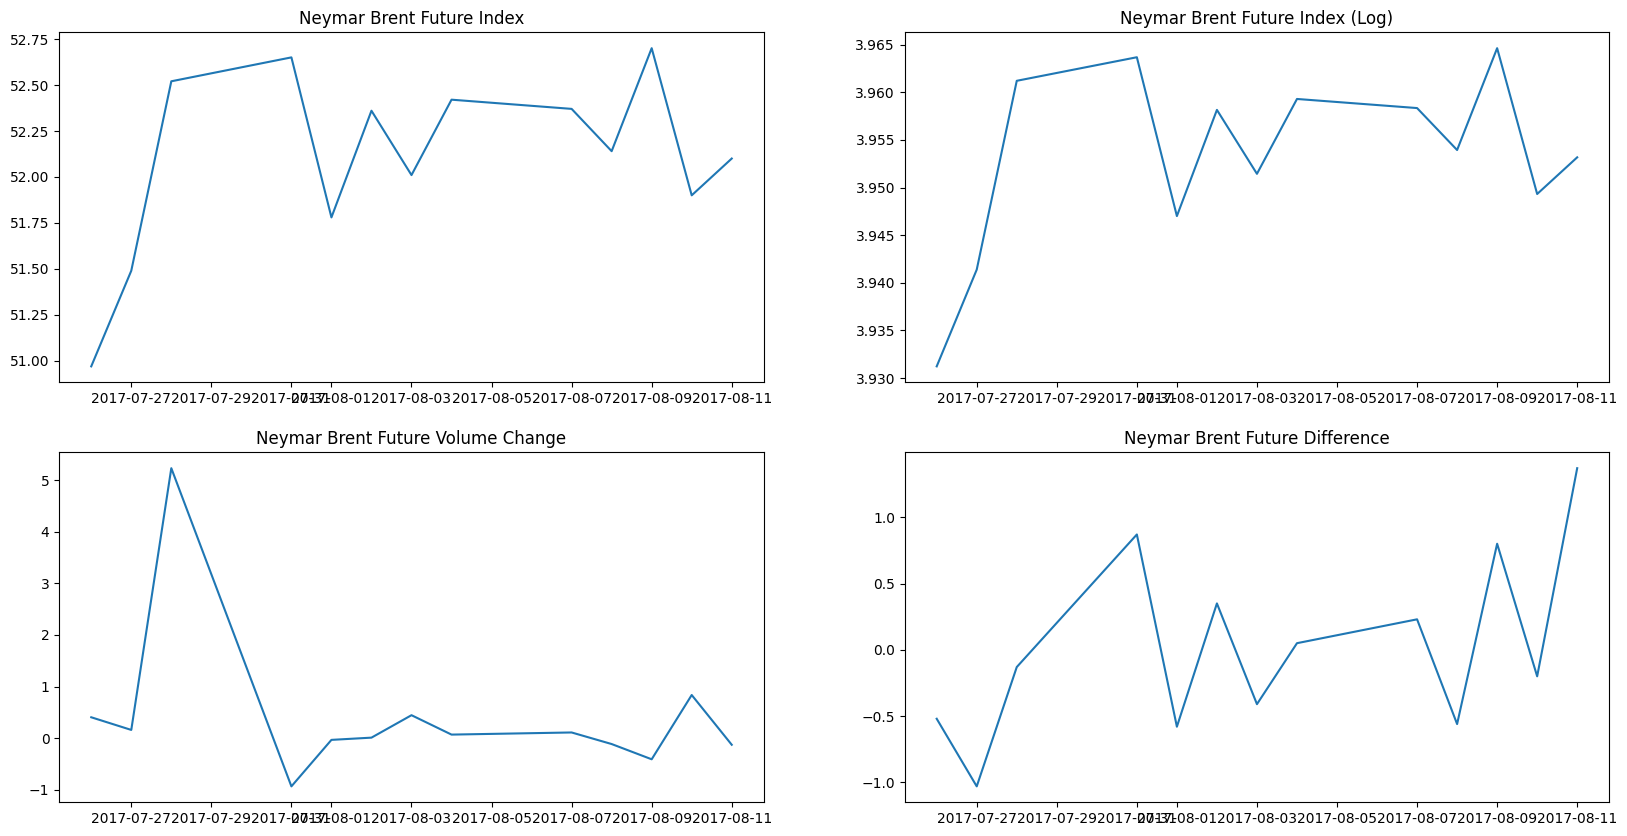

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(futures["2017-07-26":"2017-08-13"].index, futures["2017-07-26":"2017-08-13"]["Price"])
axs[0, 0].set_title("Neymar Brent Future Index")

axs[0, 1].plot(futures["2017-07-26":"2017-08-13"].index, futures["2017-07-26":"2017-08-13"]["price_log"])
axs[0, 1].set_title("Neymar Brent Future Index (Log)")

axs[1, 0].plot(futures["2017-07-26":"2017-08-13"].index, futures["2017-07-26":"2017-08-13"]["volume_change"])
axs[1, 0].set_title("Neymar Brent Future Volume Change")

axs[1, 1].plot(futures["2017-07-26":"2017-08-13"].index, futures["2017-07-26":"2017-08-13"]["difference"])
axs[1, 1].set_title("Neymar Brent Future Difference")

plt.show()

### TEST: Moises Caicedo, August 14 2023
Utilizing window __August 8/1 - 8/20__

__Undetected__: Could be because Caicedo was "insignificant" trade (valued < 70M)

In [38]:
start = "2023-07-25"
end = "2023-08-15"
anomaly_test(start=start, end=end, features=features)

2023-07-25 00:00:00 :: 1
2023-07-26 00:00:00 :: 1
2023-07-27 00:00:00 :: 1
2023-07-28 00:00:00 :: -1
2023-07-31 00:00:00 :: -1
2023-08-01 00:00:00 :: -1
2023-08-02 00:00:00 :: 1
2023-08-03 00:00:00 :: 1
2023-08-04 00:00:00 :: 1
2023-08-07 00:00:00 :: 1
2023-08-08 00:00:00 :: 1
2023-08-09 00:00:00 :: 1
2023-08-10 00:00:00 :: 1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: 1
2023-08-15 00:00:00 :: 1


array([ 1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

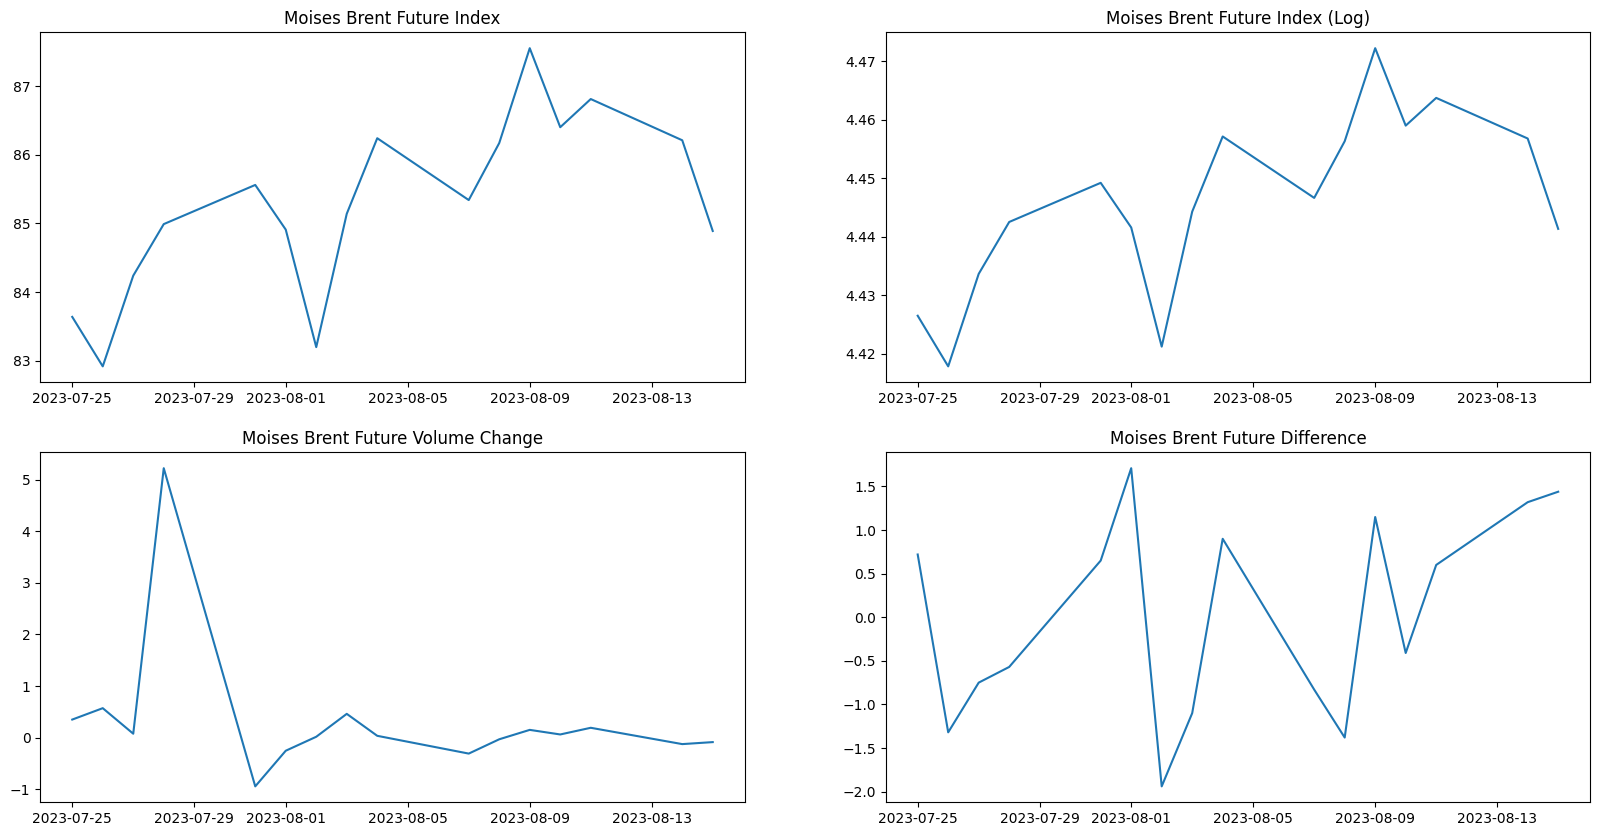

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(futures[start:end].index, futures[start:end]["Price"])
axs[0, 0].set_title("Moises Brent Future Index")

axs[0, 1].plot(futures[start:end].index, futures[start:end]["price_log"])
axs[0, 1].set_title("Moises Brent Future Index (Log)")

axs[1, 0].plot(futures[start:end].index, futures[start:end]["volume_change"])
axs[1, 0].set_title("Moises Brent Future Volume Change")

axs[1, 1].plot(futures[start:end].index, futures[start:end]["difference"])
axs[1, 1].set_title("Moises Brent Future Difference")

plt.show()

### TEST: Rando Colovani, September 1 2023
__Note__: Anomoly detected

In [40]:
start = "2023-08-30"
end = "2023-09-10"
anomaly_test(start=start, end=end, features=features)

2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-04 00:00:00 :: -1
2023-09-05 00:00:00 :: 1
2023-09-06 00:00:00 :: 1
2023-09-07 00:00:00 :: 1
2023-09-08 00:00:00 :: 1


array([-1, -1, -1, -1,  1,  1,  1,  1])

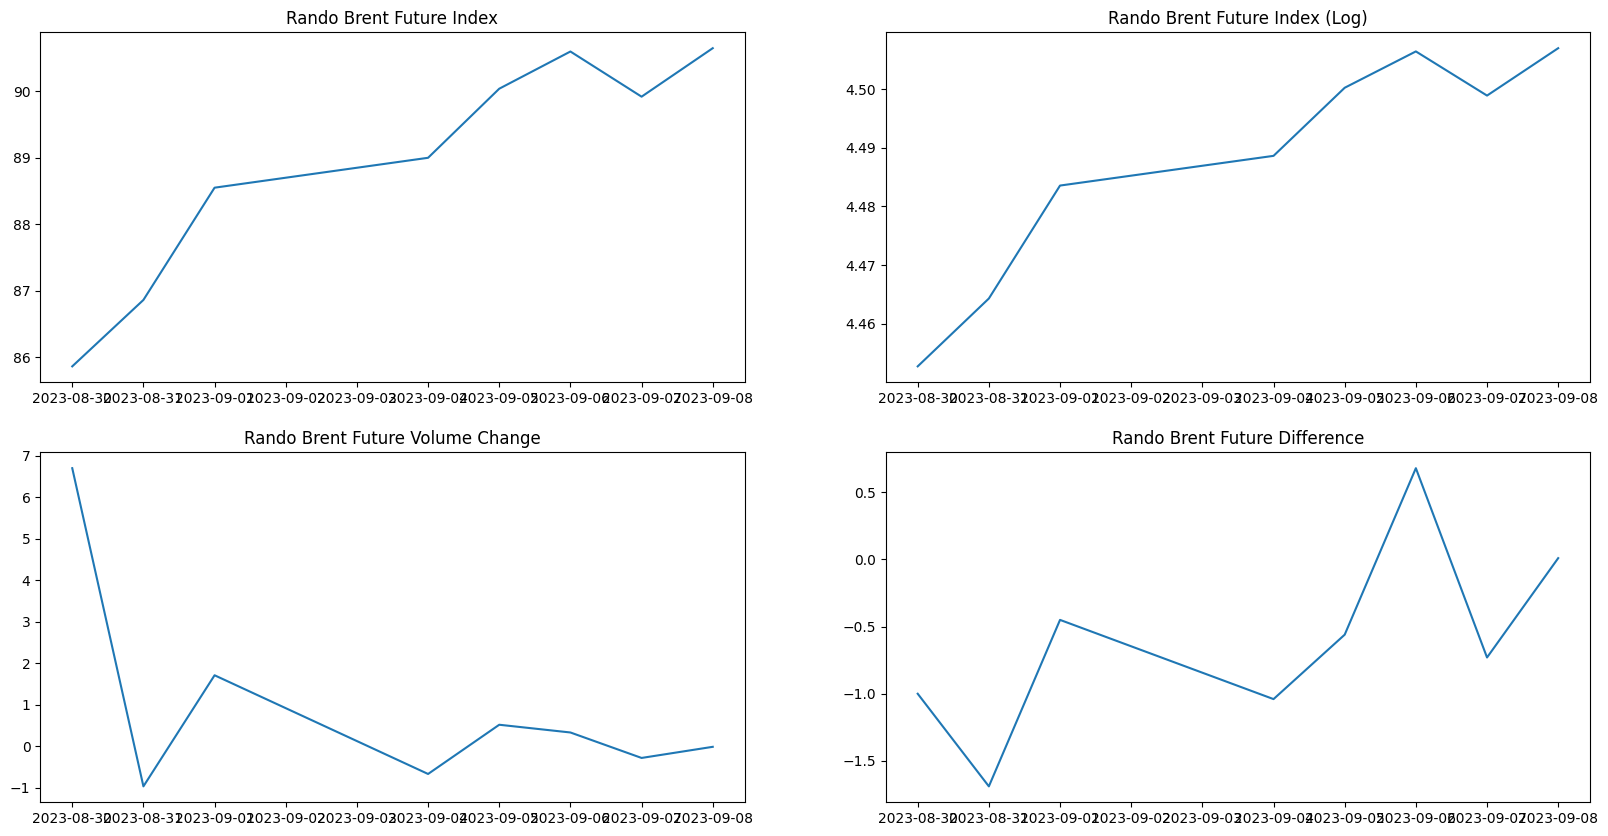

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(futures[start:end].index, futures[start:end]["Price"])
axs[0, 0].set_title("Rando Brent Future Index")

axs[0, 1].plot(futures[start:end].index, futures[start:end]["price_log"])
axs[0, 1].set_title("Rando Brent Future Index (Log)")

axs[1, 0].plot(futures[start:end].index, futures[start:end]["volume_change"])
axs[1, 0].set_title("Rando Brent Future Volume Change")

axs[1, 1].plot(futures[start:end].index, futures[start:end]["difference"])
axs[1, 1].set_title("Rando Brent Future Difference")

plt.show()

### Facebook Prophet API 

Using for anomoly testing/time series forecasting

Forecast price of Brent Futures + segment data by plotting changepoints in data

00:56:05 - cmdstanpy - INFO - Chain [1] start processing
00:56:07 - cmdstanpy - INFO - Chain [1] done processing


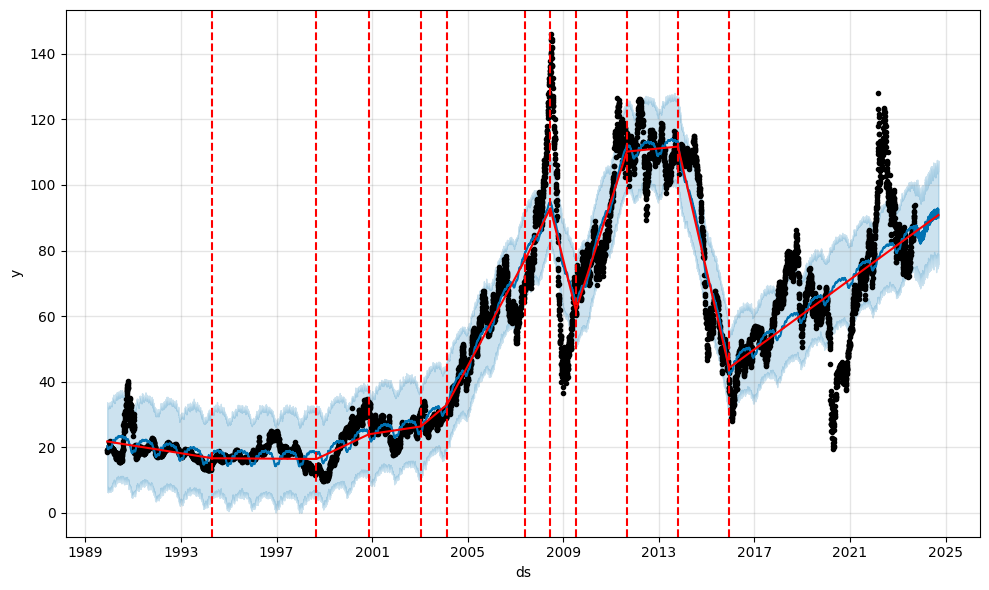

In [42]:
# create dataframe for prophet changepoint fitting
prophet_df = pd.DataFrame({
    "ds":[date for date in futures["date"]],
    "y":[price for price in futures["Price"]]
})

normal_fit = Prophet() # "normal" -> just price feature
normal_fit.fit(prophet_df) # fit model

future = normal_fit.make_future_dataframe(periods=365) # forecast future prediction
forecast = normal_fit.predict(future) # create predictions
fig = normal_fit.plot(forecast) # plot
a = add_changepoints_to_plot(fig.gca(), normal_fit, forecast) # plot changepoints

Use PCA to compress features into "one" feature and do segmentation (Prophet can only process one feature for segmentation)

In [43]:
pca = PCA(n_components=1) # flatten to one component
df_no_dates = futures.drop(labels=["date"], axis=1) # drop date column
pca.fit(df_no_dates.dropna()) # fit on no empty value df
X = pca.transform(df_no_dates.dropna()) # transform 
X

array([[-109817.31716263],
       [-105937.31714627],
       [-108957.31677986],
       ...,
       [ 189032.74719464],
       [ 196282.74734686],
       [ 203182.74741951]])

In [44]:
# create df for pca values
pca_series = pd.DataFrame({
    "ds":[date for date in futures.dropna()["date"]],
    "y":[val[0] for val in X]
})
pca_series

,ds,y
0,1989-12-01,-109817.317163
1,1989-12-04,-105937.317146
2,1989-12-05,-108957.316780
3,1989-12-06,-108447.316782
4,1989-12-07,-107047.316750
...,...,...
8626,2023-09-11,189702.745712
8627,2023-09-12,222852.742762
8628,2023-09-13,189032.747195
8629,2023-09-14,196282.747347


00:56:11 - cmdstanpy - INFO - Chain [1] start processing
00:56:11 - cmdstanpy - INFO - Chain [1] done processing


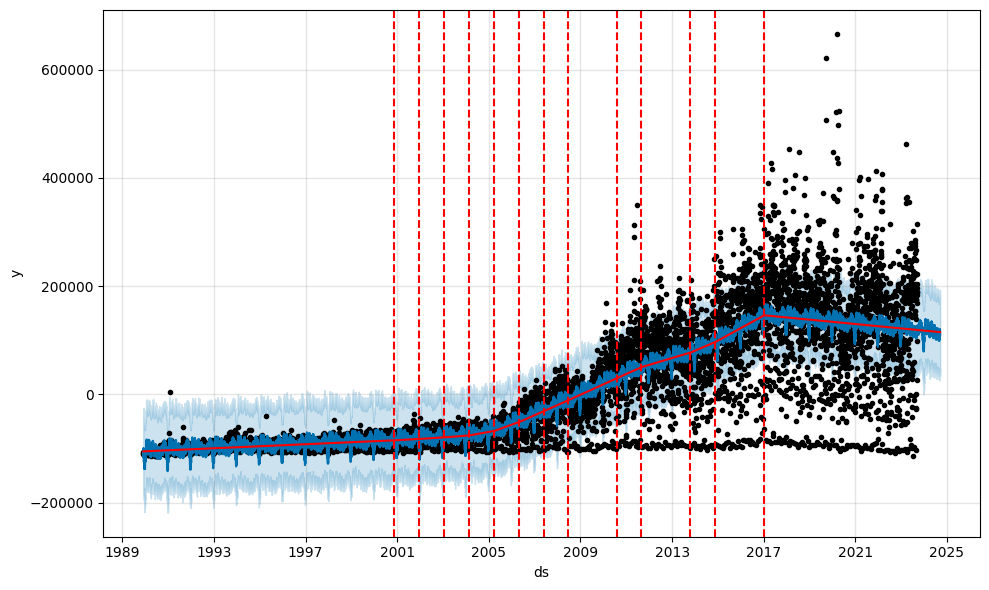

In [45]:
# partitioning and forecast for PCA fit
pca_fit = Prophet()
pca_fit.fit(pca_series)

future = pca_fit.make_future_dataframe(periods=365) # forecast future values
forecast = pca_fit.predict(future) # get predictions
fig = pca_fit.plot(forecast) # plot forecast
a = add_changepoints_to_plot(fig.gca(), pca_fit, forecast) # plot changepoints

### Anomaly Test on Partitions

Fit classifier on partitioned data so classifier is only focused on specific time period of data

Method for just reducing code typed

In [46]:
def get_changepoint(m: Prophet) -> List[pd.Timestamp]:
    '''
    Get changepoints of specified forecast fitting

    m: Prophet object which you are retrieving changepoints of 
    returns list with changepoint dates
    '''
    return list(m.changepoints.reset_index()["ds"])

In [58]:
import datetime

# anonaly testing on segment where player trade happened
def anomaly_test_segment(features: List[str], trade_date: str, curr_changepoint: List[pd.Timestamp]) -> None:
    '''
    Runs anomoly test for trade date on appropriate partition

    features: list of features (strings)
    trade_date: date (string) of trade datetime
    curr_changepoint: list of timestamps of changepoints in current Prophet fitting
    '''
    # first find time segment where trade occoured in change points
    segment_start = None
    segment_end = None
    for i in range(1, len(curr_changepoint)):
        if curr_changepoint[i] > trade_date:
            segment_start = curr_changepoint[i-1]
            segment_end = curr_changepoint[i]
            break

    # fit to segment of data
    X = create_input(futures.loc[segment_start:segment_end, features], len(features))
    clf = IsolationForest(random_state=0, contamination=0.3).fit(X)

    # test on 8 day window
    start = (trade_date-datetime.timedelta(days=8))[0]
    end = (trade_date+datetime.timedelta(days=8))[0]
    results = clf.predict(create_input(futures.loc[start:end, features], len(features)))
    print_anomalies(results, start, end)

def plot_features(trade_date: str, player_name: str, features: List[str]) -> None: 
    '''
    Plot features for given player trade/date window

    trade_date: string representing date player was traded (yyyy-mm-dd)
    player_name: name of player (for plot titles)
    features: list of features being plotted
    '''
    trade_date = pd.to_datetime([trade_date])
    start = (trade_date-datetime.timedelta(days=8))[0]
    end = (trade_date+datetime.timedelta(days=8))[0]

    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    axs[0, 0].plot(futures["date"][start:end], futures[features[0]][start:end]) # plot price
    axs[0, 0].set_title(f"{player_name} {features[0]}")

    axs[0, 1].plot(futures["date"][start:end], futures[features[1]][start:end]) # plot volume change
    axs[0, 1].set_title(f"{player_name} {features[1]}")

    axs[1, 0].plot(futures["date"][start:end], futures["Vol."][start:end]) # plot logarithmic volume
    axs[1, 0].set_title(f"{player_name} Volume")

    axs[1, 1].plot(futures["date"][start:end], futures[features[2]][start:end]) # plot change in price
    axs[1, 1].set_title(f"{player_name} {features[2]}")

In [59]:
futures.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'volume_log',
       'volume_change', 'price_log', 'difference', '3_MA', '6_MA', '10_MA',
       '365_MA', 'date'],
      dtype='object')

In [60]:
# define features for anomoly test
features = ["Price", "volume_change", "difference"]

### Normal Fit

In [61]:
# neymar -> detected
anomaly_test_segment(trade_date=pd.to_datetime(["2017-08-01"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2017-07-24 00:00:00 :: 1
2017-07-25 00:00:00 :: 1
2017-07-26 00:00:00 :: 1
2017-07-27 00:00:00 :: 1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: 1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: 1


In [62]:
futures[start:end]

,Price,Open,High,Low,Vol.,Change %,volume_log,volume_change,price_log,difference,3_MA,6_MA,10_MA,365_MA,date
Date,,,,,,,,,,,,,,,
2023-08-30,85.86,85.62,86.23,85.11,86740.0,0.0043,11.370670,6.696539,4.452718,-1.00,85.256667,84.470000,84.423,90.580164,2023-08-30
2023-08-31,86.86,86.00,86.94,85.74,11270.0,0.0116,9.329900,-0.970401,4.464298,-1.69,86.070000,85.078333,84.697,90.522493,2023-08-31
2023-09-01,88.55,86.82,88.99,86.74,380760.0,0.0195,12.849925,1.706761,4.483567,-0.45,87.090000,85.943333,85.072,90.479096,2023-09-01
2023-09-04,89.00,88.95,89.22,88.26,140670.0,0.0051,11.854172,-0.671677,4.488636,-1.04,88.136667,86.696667,85.526,90.428329,2023-09-04
2023-09-05,90.04,88.91,91.15,88.06,428450.0,0.0117,12.967929,0.514439,4.500254,-0.56,89.196667,87.633333,86.127,90.382849,2023-09-05
2023-09-06,90.60,90.12,91.10,89.25,282910.0,0.0062,12.552884,0.328091,4.506454,0.68,89.880000,88.485000,86.866,90.354164,2023-09-06
2023-09-07,89.92,90.81,90.89,89.46,213020.0,-0.0075,12.269141,-0.285503,4.498920,-0.73,90.186667,89.161667,87.522,90.324959,2023-09-07
2023-09-08,90.65,89.79,91.02,89.30,298140.0,0.0081,12.605318,-0.017402,4.507006,0.01,90.390000,89.793333,88.139,90.291726,2023-09-08


Volume and Brent fluctuation play large role in generating anomolies

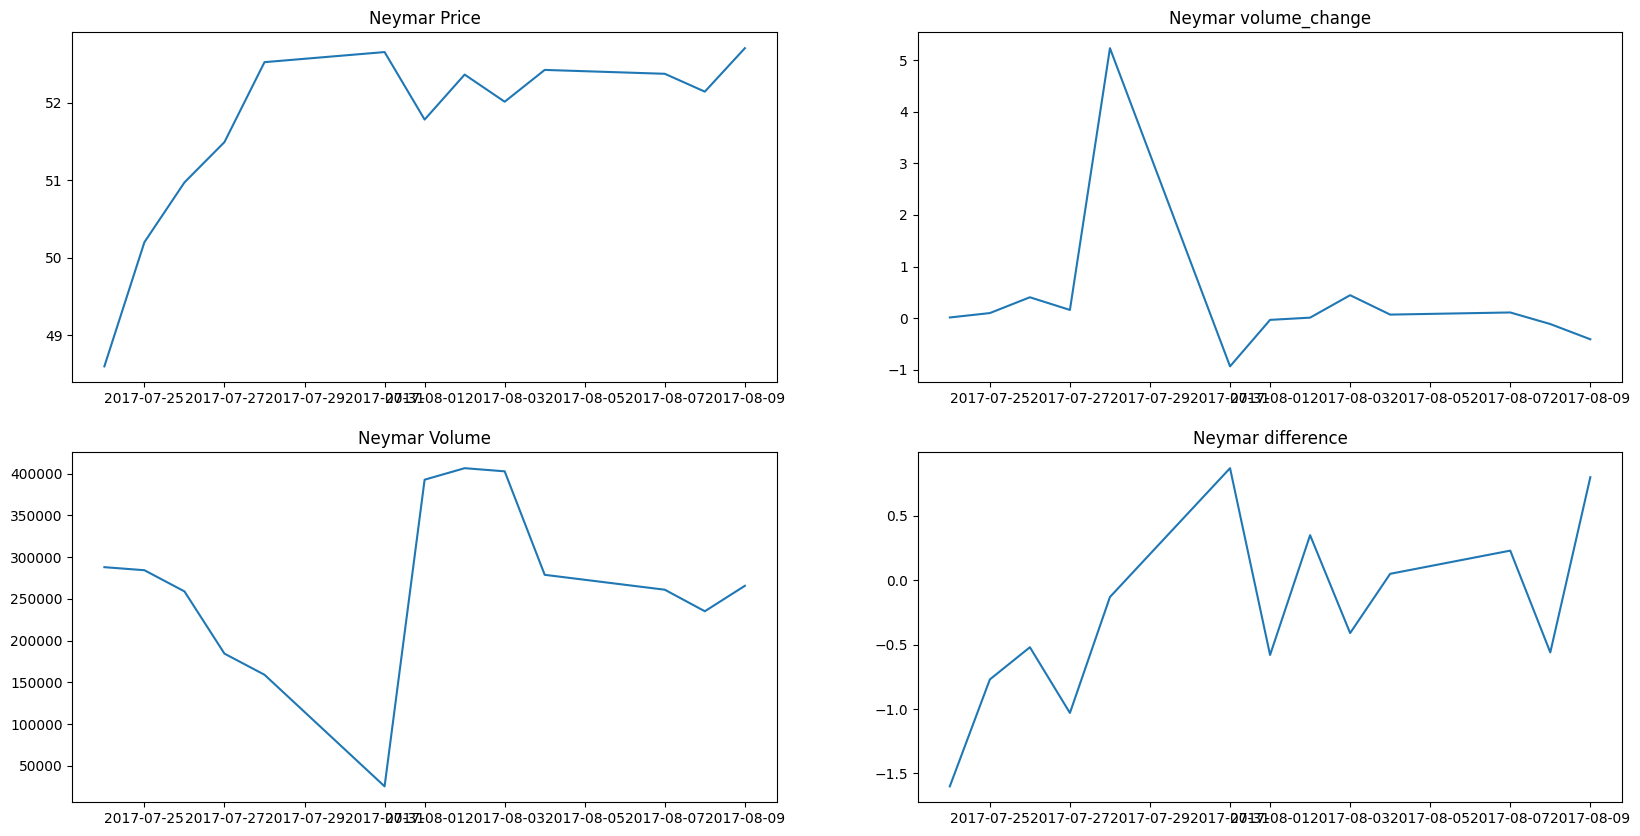

In [63]:
plot_features("2017-08-01", "Neymar", features)

In [64]:
# caciados -> not detected near trade day
anomaly_test_segment(trade_date=pd.to_datetime(["2023-08-14"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2023-08-07 00:00:00 :: 1
2023-08-08 00:00:00 :: 1
2023-08-09 00:00:00 :: 1
2023-08-10 00:00:00 :: 1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: 1
2023-08-15 00:00:00 :: 1
2023-08-16 00:00:00 :: 1
2023-08-17 00:00:00 :: 1
2023-08-18 00:00:00 :: 1
2023-08-21 00:00:00 :: 1
2023-08-22 00:00:00 :: 1


In [65]:
# detected prior in beginning of august
anomaly_test_segment(trade_date=pd.to_datetime(["2023-08-06"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2023-07-31 00:00:00 :: -1
2023-08-01 00:00:00 :: -1
2023-08-02 00:00:00 :: -1
2023-08-03 00:00:00 :: 1
2023-08-04 00:00:00 :: 1
2023-08-07 00:00:00 :: 1
2023-08-08 00:00:00 :: 1
2023-08-09 00:00:00 :: 1
2023-08-10 00:00:00 :: 1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: 1


Similar pattern here, large fluctuation in Brent value and volume causing anomoly prior to trade date

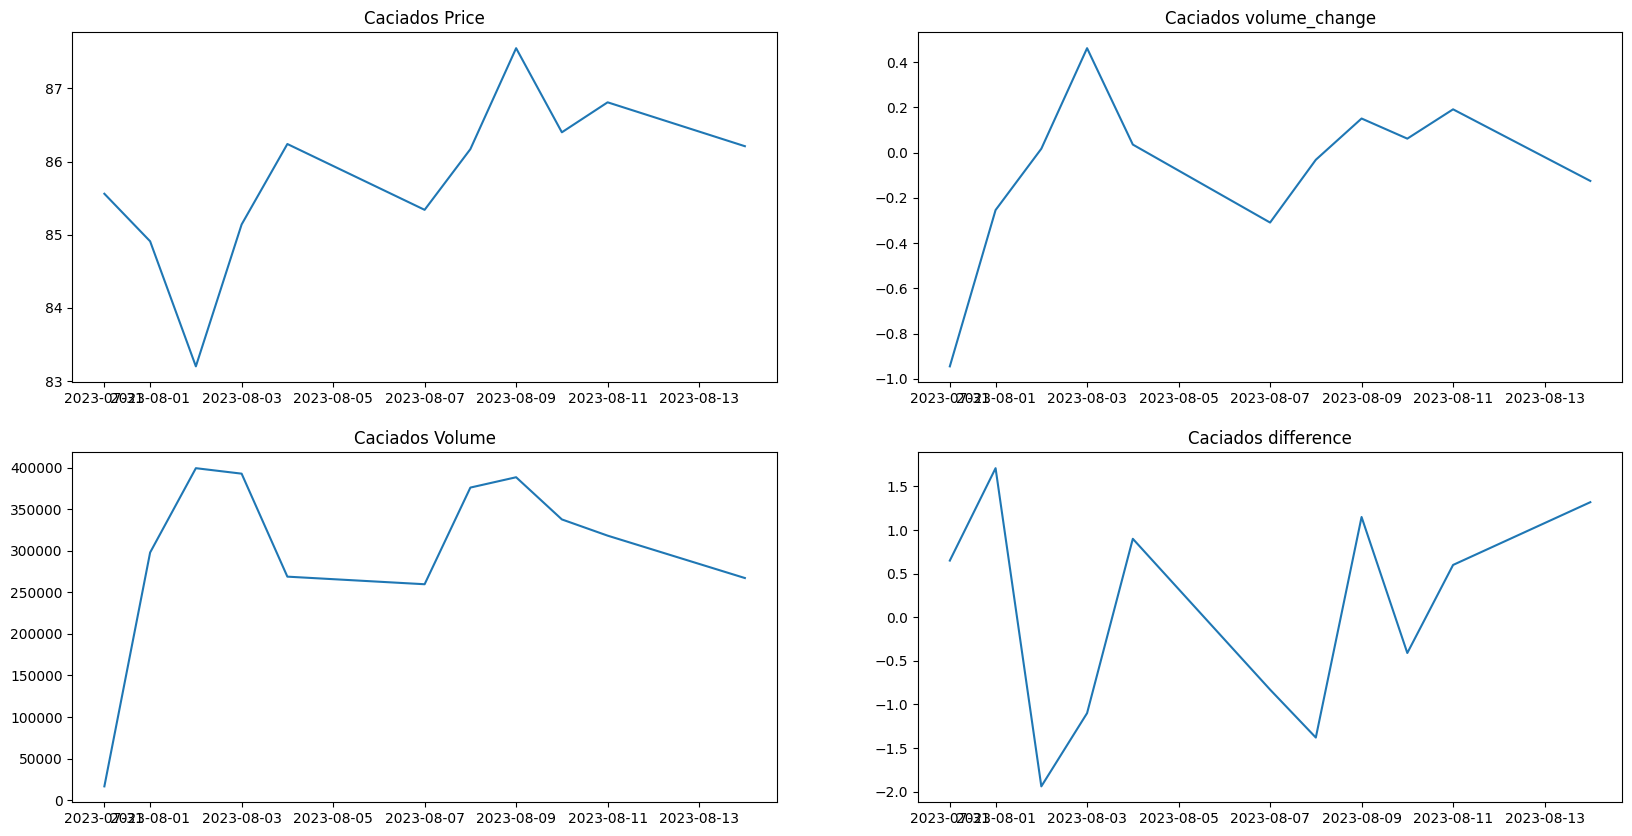

In [66]:
plot_features("2023-08-06", "Caciados", features)

In [67]:
# colovani -> detected
anomaly_test_segment(trade_date=pd.to_datetime(["2023-09-01"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2023-08-24 00:00:00 :: 1
2023-08-25 00:00:00 :: -1
2023-08-28 00:00:00 :: 1
2023-08-29 00:00:00 :: 1
2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-04 00:00:00 :: -1
2023-09-05 00:00:00 :: 1
2023-09-06 00:00:00 :: -1
2023-09-07 00:00:00 :: 1
2023-09-08 00:00:00 :: 1


Same volume fluctuation seen here

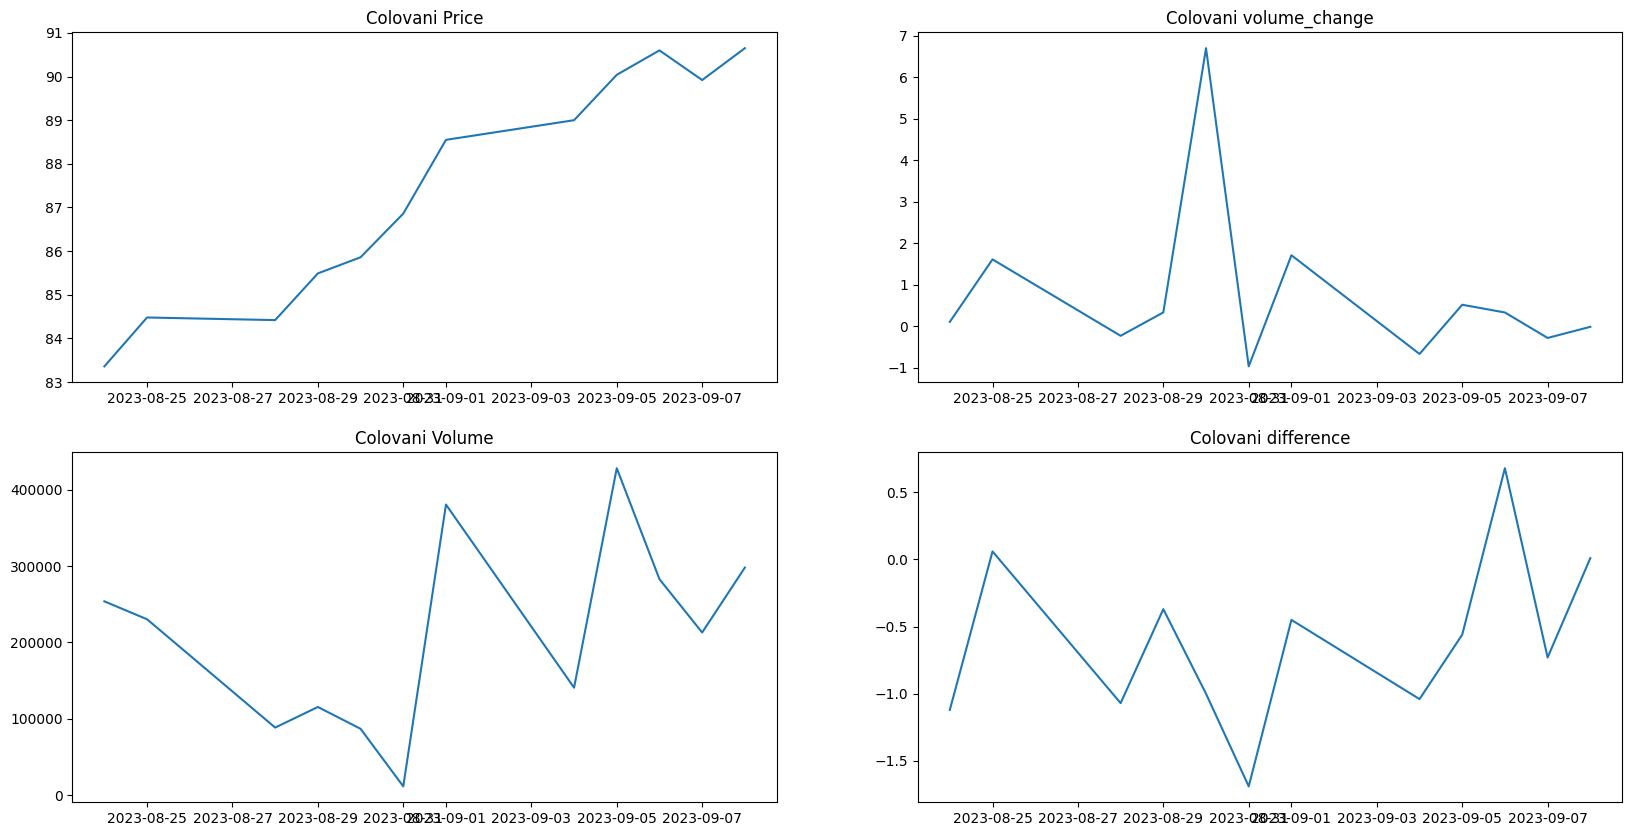

In [68]:
plot_features("2023-09-01", "Colovani", features)

### PCA Fit

In [69]:
# neymar -> detected, same detections
anomaly_test_segment(trade_date=pd.to_datetime(["2017-08-01"]), features=features, curr_changepoint=get_changepoint(pca_fit))

2017-07-24 00:00:00 :: 1
2017-07-25 00:00:00 :: 1
2017-07-26 00:00:00 :: 1
2017-07-27 00:00:00 :: 1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: 1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: 1


In [70]:
# caciados -> early detection
anomaly_test_segment(trade_date=pd.to_datetime(["2023-08-14"]), features=features, curr_changepoint=get_changepoint(pca_fit))

2023-08-07 00:00:00 :: 1
2023-08-08 00:00:00 :: 1
2023-08-09 00:00:00 :: 1
2023-08-10 00:00:00 :: 1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: 1
2023-08-15 00:00:00 :: 1
2023-08-16 00:00:00 :: 1
2023-08-17 00:00:00 :: 1
2023-08-18 00:00:00 :: 1
2023-08-21 00:00:00 :: 1
2023-08-22 00:00:00 :: 1


In [71]:
# detected prior in beginning of august
anomaly_test_segment(trade_date=pd.to_datetime(["2023-08-06"]), features=features, curr_changepoint=get_changepoint(pca_fit))

2023-07-31 00:00:00 :: -1
2023-08-01 00:00:00 :: -1
2023-08-02 00:00:00 :: -1
2023-08-03 00:00:00 :: 1
2023-08-04 00:00:00 :: 1
2023-08-07 00:00:00 :: 1
2023-08-08 00:00:00 :: 1
2023-08-09 00:00:00 :: 1
2023-08-10 00:00:00 :: 1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: 1


In [72]:
# colovani -> detected
anomaly_test_segment(trade_date=pd.to_datetime(["2023-09-01"]), features=features, curr_changepoint=get_changepoint(pca_fit))

2023-08-24 00:00:00 :: 1
2023-08-25 00:00:00 :: -1
2023-08-28 00:00:00 :: 1
2023-08-29 00:00:00 :: 1
2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-04 00:00:00 :: -1
2023-09-05 00:00:00 :: 1
2023-09-06 00:00:00 :: -1
2023-09-07 00:00:00 :: 1
2023-09-08 00:00:00 :: 1


## One Class SVM 

In [73]:
futures.loc[:, features]

,Price,volume_change,difference
Date,,,
1989-12-01,18.66,-0.498715,-0.50
1989-12-04,19.16,0.634454,0.12
1989-12-05,19.04,-0.096774,-0.11
1989-12-06,19.15,-0.209895,-0.10
1989-12-07,19.25,0.973373,0.13
...,...,...,...
2023-09-11,90.64,-0.098494,-1.42
2023-09-12,92.06,0.111709,0.18
2023-09-13,91.88,-0.023387,-1.82


In [74]:
# one class SVM test run
clf = OneClassSVM(gamma="auto").fit(create_input(futures.loc[:, features], len(features)))
X = create_input(futures.loc["2017-07-27":"2017-08-10", features], len(features))
results = clf.predict(X)

# neymar (8/1/17) -> window: 2017-07-20 2017-08-10
print_anomalies(results, start="2017-07-27", end="2017-08-10")

2017-07-27 00:00:00 :: -1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: -1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: -1
2017-08-10 00:00:00 :: -1


In [75]:
from sklearn.svm import OneClassSVM

# anonaly testing on segment where player trade happened with SVM 
def anomaly_test_segment_svm(features, trade_date, curr_changepoints):
    '''
    Runs anomoly test on appropriate partition for trade date

    features: list of features (strings)
    trade_date: date (string) of trade datetime
    curr_changepoint: list of timestamps of changepoints in current Prophet fitting
    '''
    # first find time segment where trade occoured in change points
    segment_start = None
    segment_end = None
    for i in range(1, len(curr_changepoints)):
        if curr_changepoints[i] > trade_date:
            segment_start = curr_changepoints[i-1]
            segment_end = curr_changepoints[i]

    # fit to segment of data
    X = create_input(futures.loc[segment_start:segment_end, features].dropna(), len(features))
    clf = OneClassSVM(gamma="auto").fit(X)

    # test on 8 day window
    start = (trade_date-datetime.timedelta(days=8))[0]
    end = (trade_date+datetime.timedelta(days=8))[0]
    results = clf.predict(create_input(futures.loc[start:end, features], len(features)))
    print_anomalies(results, start, end)

### __Features__: Price, volume change, difference

In [76]:
# define features
features = ["Price", "volume_change", "difference"]

In [77]:
# neymar -> detected
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2017-08-01"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2017-07-24 00:00:00 :: -1
2017-07-25 00:00:00 :: 1
2017-07-26 00:00:00 :: -1
2017-07-27 00:00:00 :: -1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: -1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: -1


In [78]:
# colovani -> detected, but all dates are anomalies
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-09-01"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2023-08-24 00:00:00 :: -1
2023-08-25 00:00:00 :: -1
2023-08-28 00:00:00 :: -1
2023-08-29 00:00:00 :: -1
2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-04 00:00:00 :: -1
2023-09-05 00:00:00 :: -1
2023-09-06 00:00:00 :: -1
2023-09-07 00:00:00 :: -1
2023-09-08 00:00:00 :: -1


In [79]:
# neymar 2023 -> detected
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-08-14"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2023-08-07 00:00:00 :: -1
2023-08-08 00:00:00 :: -1
2023-08-09 00:00:00 :: -1
2023-08-10 00:00:00 :: -1
2023-08-11 00:00:00 :: -1
2023-08-14 00:00:00 :: -1
2023-08-15 00:00:00 :: -1
2023-08-16 00:00:00 :: 1
2023-08-17 00:00:00 :: 1
2023-08-18 00:00:00 :: 1
2023-08-21 00:00:00 :: 1
2023-08-22 00:00:00 :: -1


### __Features__: Log(Price), volume change, difference

In [80]:
features = ["price_log", "volume_change", "difference"]

In [81]:
# LOG neymar
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2017-08-01"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2017-07-24 00:00:00 :: -1
2017-07-25 00:00:00 :: 1
2017-07-26 00:00:00 :: 1
2017-07-27 00:00:00 :: 1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: 1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: 1


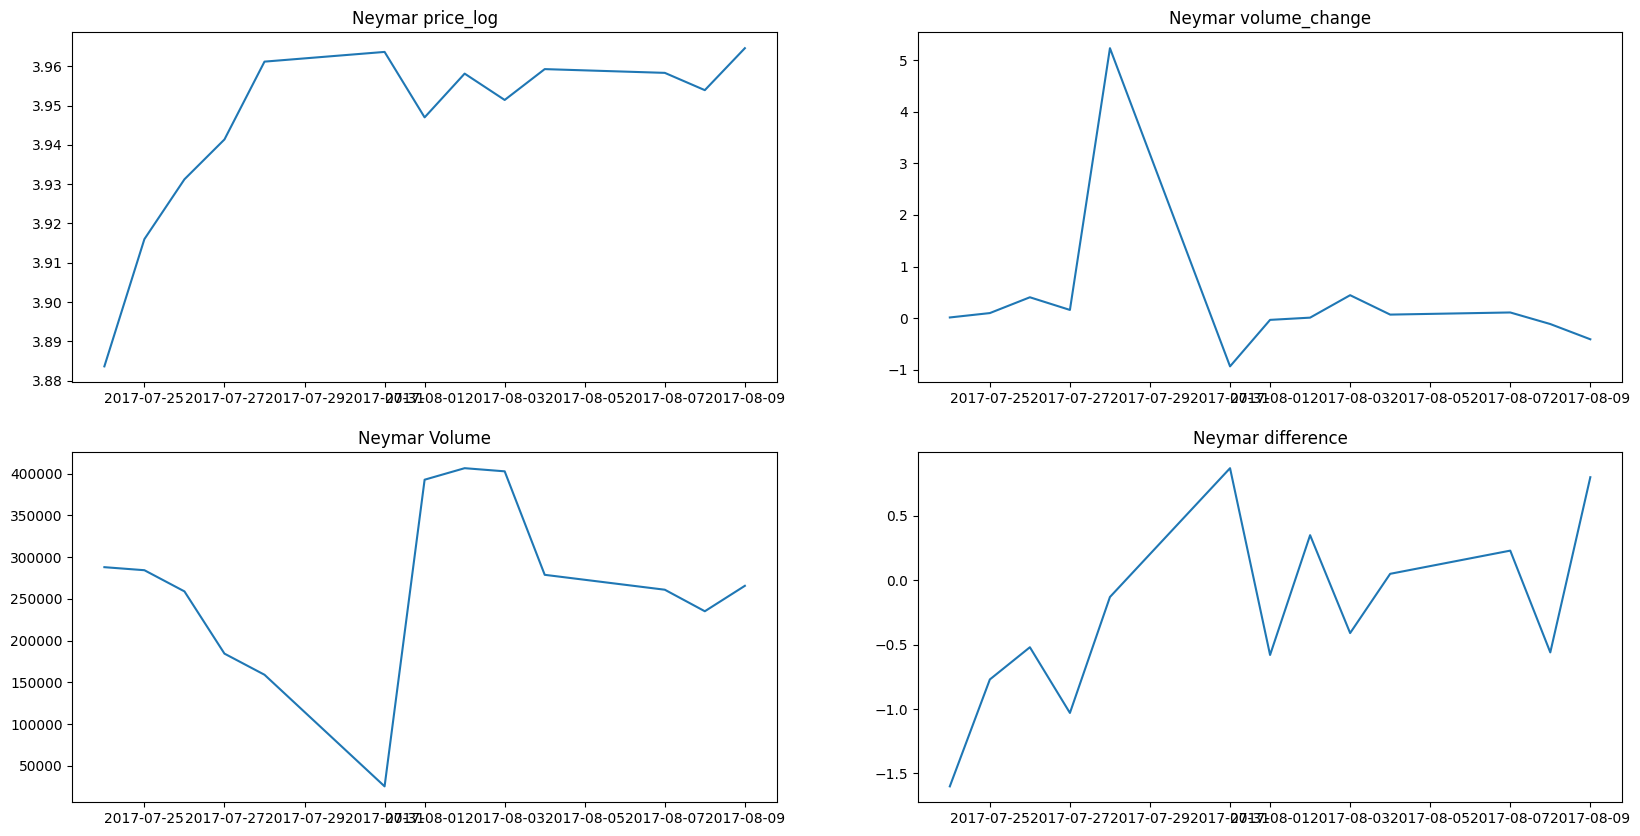

In [82]:
plot_features("2017-08-01", "Neymar", features=features)

In [83]:
# LOG colovani -> reduced number of anomalies
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-09-01"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2023-08-24 00:00:00 :: -1
2023-08-25 00:00:00 :: -1
2023-08-28 00:00:00 :: -1
2023-08-29 00:00:00 :: 1
2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-04 00:00:00 :: -1
2023-09-05 00:00:00 :: -1
2023-09-06 00:00:00 :: -1
2023-09-07 00:00:00 :: -1
2023-09-08 00:00:00 :: 1


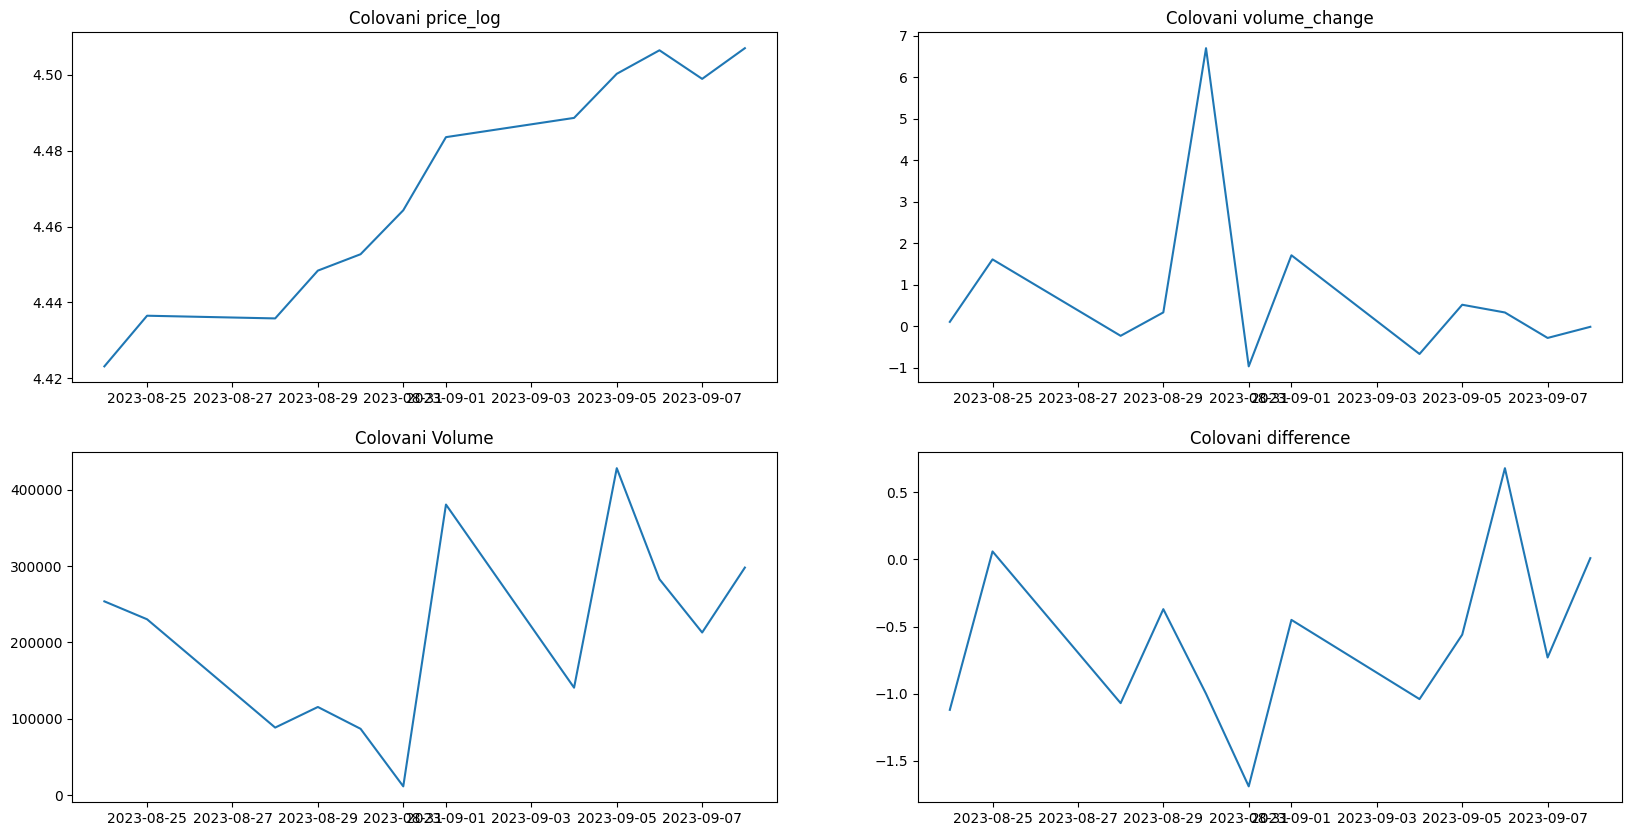

In [84]:
plot_features("2023-09-01", "Colovani", features=features)

In [85]:
# LOG NEYMAR 23
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-08-14"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2023-08-07 00:00:00 :: -1
2023-08-08 00:00:00 :: -1
2023-08-09 00:00:00 :: -1
2023-08-10 00:00:00 :: 1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: -1
2023-08-15 00:00:00 :: -1
2023-08-16 00:00:00 :: 1
2023-08-17 00:00:00 :: 1
2023-08-18 00:00:00 :: 1
2023-08-21 00:00:00 :: 1
2023-08-22 00:00:00 :: -1


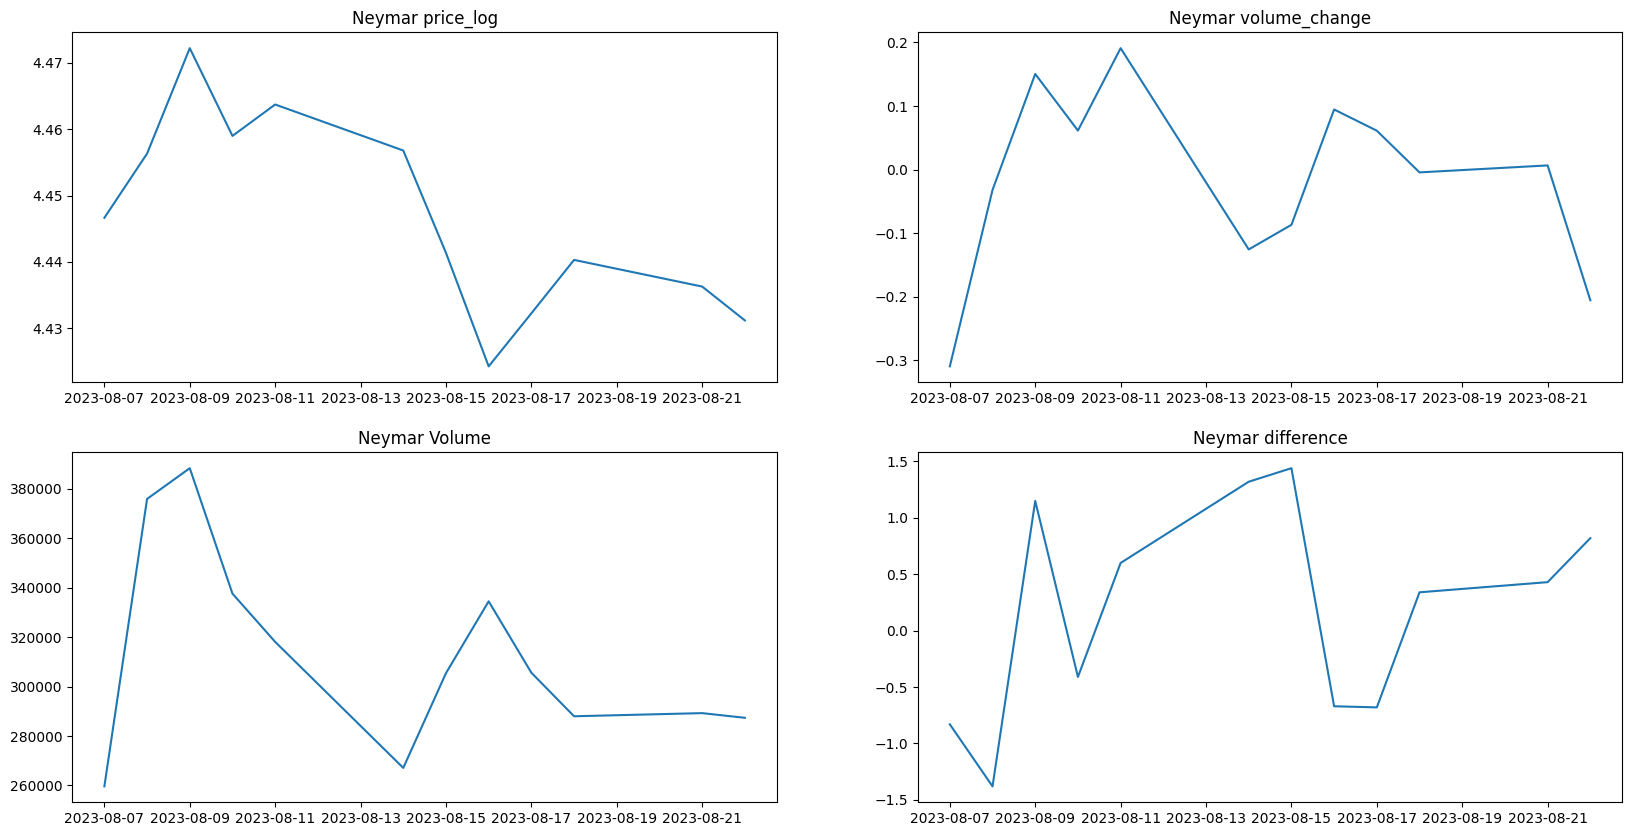

In [86]:
plot_features("2023-08-14", "Neymar", features=features)

__Large Takeaway__: Volume always fluctuates before a huge player (especially Neymar in both Neymar trades)

__Note__: Logging price results in less variance in anomolies (more precise) with One-class SVMs

### Analyze change (derivative) of Brent Future
__Note__: Similar detection, no differences

In [87]:
# lets say this is our "derivative" -> essentially we want to see large fluctuations in the brent futures
derivative_series = pd.DataFrame({
    "ds": [date for date in prophet_df["ds"][:-1]], # drop last date
    "y": np.diff(prophet_df["y"])
})
derivative_series

,ds,y
0,1989-12-01,0.50
1,1989-12-04,-0.12
2,1989-12-05,0.11
3,1989-12-06,0.10
4,1989-12-07,-0.13
...,...,...
8625,2023-09-08,-0.01
8626,2023-09-11,1.42
8627,2023-09-12,-0.18
8628,2023-09-13,1.82


01:00:34 - cmdstanpy - INFO - Chain [1] start processing
01:00:34 - cmdstanpy - INFO - Chain [1] done processing


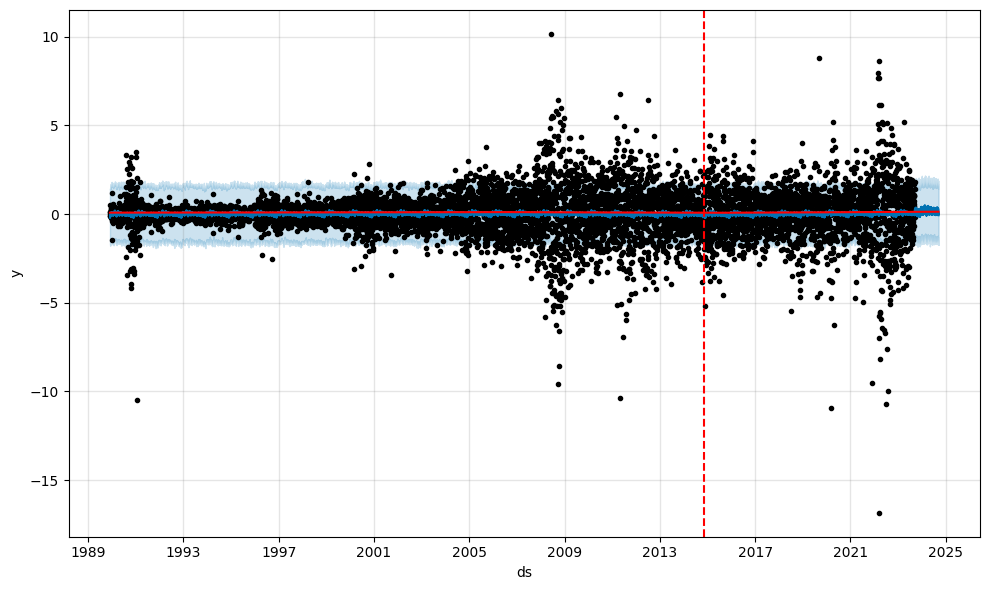

In [88]:
derivative_fit = Prophet() # create fitting on derivative
derivative_fit.fit(derivative_series)

future = derivative_fit.make_future_dataframe(periods=365)
forecast = derivative_fit.predict(future)
fig = derivative_fit.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), derivative_fit, forecast)

In [89]:
deriv_list = derivative_series["y"].to_list()
deriv_list.append(0) # match dimension size 
futures["derivative"] = deriv_list
futures

,Price,Open,High,Low,Vol.,Change %,volume_log,volume_change,price_log,difference,3_MA,6_MA,10_MA,365_MA,date,derivative
Date,,,,,,,,,,,,,,,,
1989-12-01,18.66,18.54,18.70,18.50,3900.0,0.0092,8.268732,-0.498715,2.926382,-0.50,18.410000,18.400000,18.447,16.253397,1989-12-01,0.50
1989-12-04,19.16,19.05,19.29,19.00,7780.0,0.0268,8.959312,0.634454,2.952825,0.12,18.770000,18.520000,18.500,16.264521,1989-12-04,-0.12
1989-12-05,19.04,19.05,19.26,19.03,4760.0,-0.0063,8.468003,-0.096774,2.946542,-0.11,18.953333,18.620000,18.546,16.274849,1989-12-05,0.11
1989-12-06,19.15,19.00,19.20,18.97,5270.0,0.0058,8.569786,-0.209895,2.952303,-0.10,19.116667,18.763333,18.610,16.286630,1989-12-06,0.10
1989-12-07,19.25,19.22,19.41,19.22,6670.0,0.0052,8.805375,0.973373,2.957511,0.13,19.146667,18.958333,18.700,16.299370,1989-12-07,-0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11,90.64,90.83,91.45,90.11,303420.0,-0.0001,12.622873,-0.098494,4.506896,-1.42,90.403333,90.141667,88.761,90.270247,2023-09-11,1.42
2023-09-12,92.06,90.62,92.40,90.52,336570.0,0.0157,12.726561,0.111709,4.522441,0.18,91.116667,90.651667,89.418,90.235781,2023-09-12,-0.18
2023-09-13,91.88,92.04,92.84,91.63,302750.0,-0.0020,12.620663,-0.023387,4.520483,-1.82,91.526667,90.958333,90.020,90.189479,2023-09-13,1.82


### __Features__: Price, volume change, derivative

In [90]:
features = ["Price", "volume_change", "derivative"]

In [91]:
# neymar -> detected
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2017-08-01"]), features=features, curr_changepoints=get_changepoint(derivative_fit))

2017-07-24 00:00:00 :: -1
2017-07-25 00:00:00 :: 1
2017-07-26 00:00:00 :: -1
2017-07-27 00:00:00 :: -1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: -1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: -1


In [92]:
# colovani -> detected
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-09-01"]), features=features, curr_changepoints=get_changepoint(derivative_fit))

2023-08-24 00:00:00 :: -1
2023-08-25 00:00:00 :: -1
2023-08-28 00:00:00 :: -1
2023-08-29 00:00:00 :: -1
2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-04 00:00:00 :: -1
2023-09-05 00:00:00 :: -1
2023-09-06 00:00:00 :: -1
2023-09-07 00:00:00 :: -1
2023-09-08 00:00:00 :: -1


In [93]:
# neymar 2023 -> detected with less variance in anomolies detected
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-08-14"]), features=features, curr_changepoints=get_changepoint(derivative_fit))

2023-08-07 00:00:00 :: -1
2023-08-08 00:00:00 :: -1
2023-08-09 00:00:00 :: -1
2023-08-10 00:00:00 :: -1
2023-08-11 00:00:00 :: -1
2023-08-14 00:00:00 :: -1
2023-08-15 00:00:00 :: -1
2023-08-16 00:00:00 :: 1
2023-08-17 00:00:00 :: 1
2023-08-18 00:00:00 :: 1
2023-08-21 00:00:00 :: 1
2023-08-22 00:00:00 :: -1


__Note__: a lot more variance, try log(Price)

### __Features__: Log(Price), volume change, derivative

In [94]:
features = ["price_log", "volume_change", "derivative"]

In [95]:
# neymar -> detected
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2017-08-01"]), features=features, curr_changepoints=get_changepoint(derivative_fit))

2017-07-24 00:00:00 :: -1
2017-07-25 00:00:00 :: 1
2017-07-26 00:00:00 :: 1
2017-07-27 00:00:00 :: 1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: 1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: 1


In [96]:
# colovani -> detected
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-09-01"]), features=features, curr_changepoints=get_changepoint(derivative_fit))

2023-08-24 00:00:00 :: -1
2023-08-25 00:00:00 :: -1
2023-08-28 00:00:00 :: -1
2023-08-29 00:00:00 :: 1
2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-04 00:00:00 :: -1
2023-09-05 00:00:00 :: -1
2023-09-06 00:00:00 :: -1
2023-09-07 00:00:00 :: -1
2023-09-08 00:00:00 :: 1


In [97]:
# neymar 2023 -> detected with less variance in anomolies detected
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-08-14"]), features=features, curr_changepoints=get_changepoint(derivative_fit))

2023-08-07 00:00:00 :: -1
2023-08-08 00:00:00 :: -1
2023-08-09 00:00:00 :: -1
2023-08-10 00:00:00 :: 1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: -1
2023-08-15 00:00:00 :: -1
2023-08-16 00:00:00 :: 1
2023-08-17 00:00:00 :: 1
2023-08-18 00:00:00 :: 1
2023-08-21 00:00:00 :: 1
2023-08-22 00:00:00 :: -1


# WTI Analysis

Using the following tests (no need to use tests that didn't help previously):
1. Isolation Tree
2. One Class SVM (Price fit)
3. One Class SVM (Derivative fit)

### Preprocessing

In [98]:
# add to whole df we use throughout notebook 
futures["wti"] = df["wti"] # add in wti values to whole frame 
futures["wti_diff"] = futures["wti"].diff()
futures["wti_log"] = futures["wti"].apply(lambda val: np.log(val))

# wti data starts at 1992 -> drop anything before
futures = futures.dropna()
futures

,Price,Open,High,Low,Vol.,Change %,volume_log,volume_change,price_log,difference,3_MA,6_MA,10_MA,365_MA,date,derivative,wti,wti_diff,wti_log
Date,,,,,,,,,,,,,,,,,,,
1989-12-04,19.16,19.05,19.29,19.00,7780.0,0.0268,8.959312,0.634454,2.952825,0.12,18.770000,18.520000,18.500,16.264521,1989-12-04,-0.12,20.24,-0.02,3.007661
1989-12-05,19.04,19.05,19.26,19.03,4760.0,-0.0063,8.468003,-0.096774,2.946542,-0.11,18.953333,18.620000,18.546,16.274849,1989-12-05,0.11,20.22,-0.02,3.006672
1989-12-06,19.15,19.00,19.20,18.97,5270.0,0.0058,8.569786,-0.209895,2.952303,-0.10,19.116667,18.763333,18.610,16.286630,1989-12-06,0.10,20.46,0.24,3.018472
1989-12-07,19.25,19.22,19.41,19.22,6670.0,0.0052,8.805375,0.973373,2.957511,0.13,19.146667,18.958333,18.700,16.299370,1989-12-07,-0.13,20.45,-0.01,3.017983
1989-12-08,19.12,19.15,19.17,19.04,3380.0,-0.0068,8.125631,-0.339844,2.950735,0.01,19.173333,19.063333,18.768,16.312438,1989-12-08,-0.01,20.41,-0.04,3.016025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11,90.64,90.83,91.45,90.11,303420.0,-0.0001,12.622873,-0.098494,4.506896,-1.42,90.403333,90.141667,88.761,90.270247,2023-09-11,1.42,87.3,-0.21,4.469350
2023-09-12,92.06,90.62,92.40,90.52,336570.0,0.0157,12.726561,0.111709,4.522441,0.18,91.116667,90.651667,89.418,90.235781,2023-09-12,-0.18,88.87,1.57,4.487175
2023-09-13,91.88,92.04,92.84,91.63,302750.0,-0.0020,12.620663,-0.023387,4.520483,-1.82,91.526667,90.958333,90.020,90.189479,2023-09-13,1.82,88.59,-0.28,4.484019


## Isolation Tree


### __Features__: WTI, volume change, WTI Derivative

In [99]:
features = ["wti", "volume_change", "wti_diff"]

In [100]:
# neymar -> detected
anomaly_test_segment(trade_date=pd.to_datetime(["2017-08-01"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2017-07-24 00:00:00 :: 1
2017-07-25 00:00:00 :: 1
2017-07-26 00:00:00 :: 1
2017-07-27 00:00:00 :: 1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: 1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: 1


__VERY IMPORTANT__: Notice that WTI started climbing way before volume fluctuation, WTI signals squeeze earlier than Brent

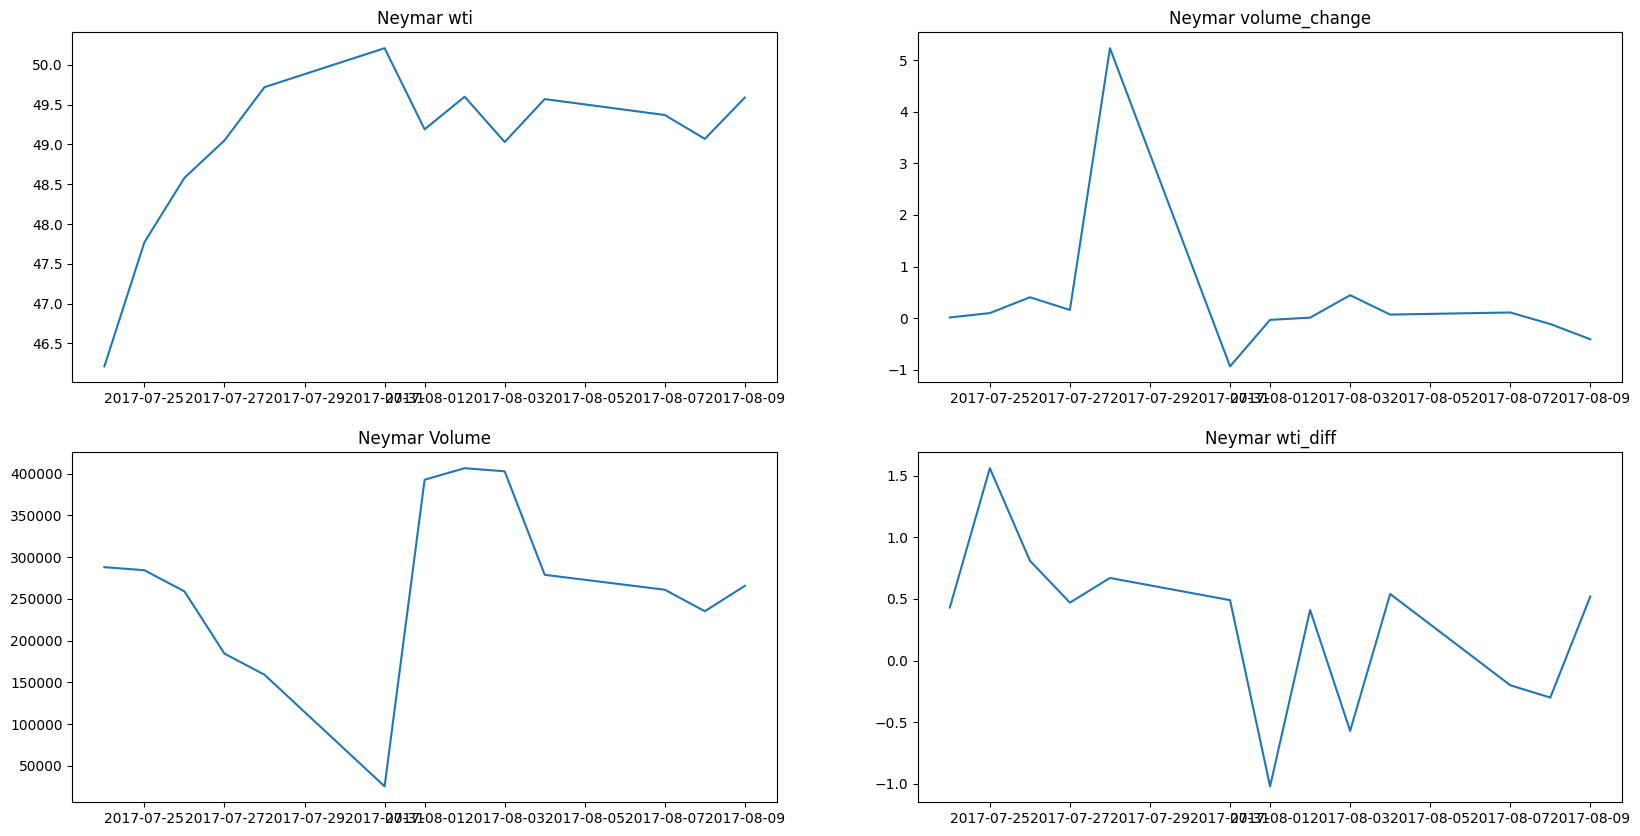

In [101]:
plot_features("2017-08-01", "Neymar", features=features)

In [102]:
# caciados -> early detection and day after, better than brent
anomaly_test_segment(trade_date=pd.to_datetime(["2023-08-14"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2023-08-07 00:00:00 :: 1
2023-08-08 00:00:00 :: 1
2023-08-09 00:00:00 :: 1
2023-08-10 00:00:00 :: -1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: 1
2023-08-15 00:00:00 :: -1
2023-08-16 00:00:00 :: 1
2023-08-17 00:00:00 :: 1
2023-08-18 00:00:00 :: 1
2023-08-21 00:00:00 :: 1
2023-08-22 00:00:00 :: 1


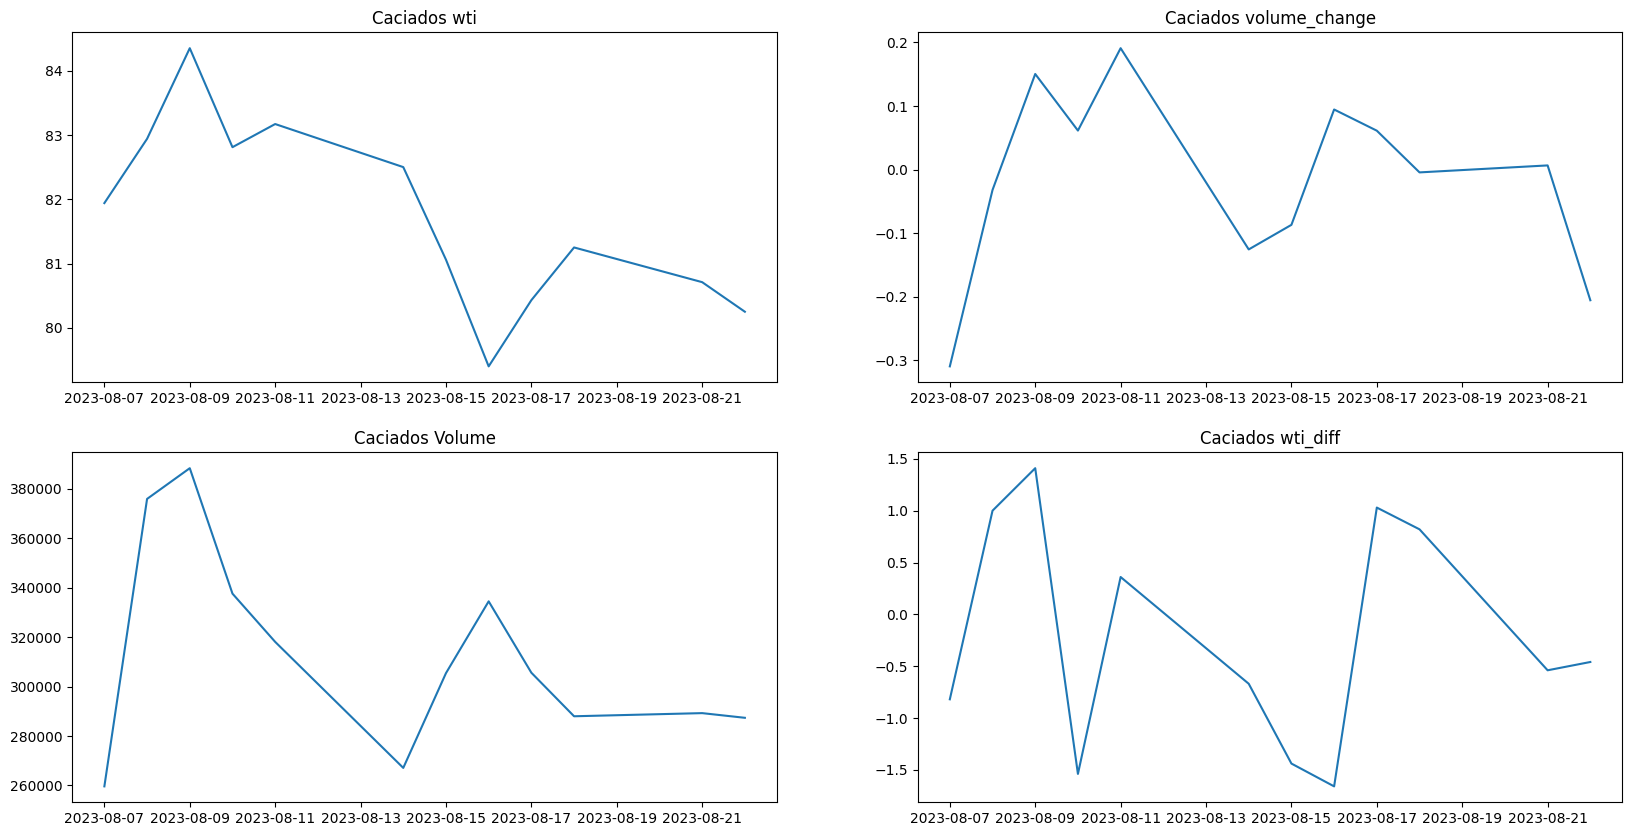

In [103]:
plot_features("2023-08-14", "Caciados", features=features)

In [104]:
# colovani -> detected
# NOTICE: more accurate than brent, less anomolies (more precise)
anomaly_test_segment(trade_date=pd.to_datetime(["2023-09-01"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2023-08-24 00:00:00 :: 1
2023-08-25 00:00:00 :: -1
2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-06 00:00:00 :: 1
2023-09-07 00:00:00 :: 1
2023-09-08 00:00:00 :: 1


In [105]:
# NOTICE: somewhat scattered still but less anomolies (more accurate)
anomaly_test_segment(trade_date=pd.to_datetime(["2023-05-01"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2023-04-24 00:00:00 :: 1
2023-04-25 00:00:00 :: 1
2023-04-26 00:00:00 :: -1
2023-04-27 00:00:00 :: -1
2023-04-28 00:00:00 :: -1
2023-05-03 00:00:00 :: -1
2023-05-04 00:00:00 :: 1
2023-05-05 00:00:00 :: -1


### __Features__: log(WTI), volume change, WTI Derivative

In [106]:
features = ["wti_log", "volume_change", "wti_diff"]

In [107]:
# neymar -> detected
# NOTICE: detected the EXACT day of trade
anomaly_test_segment(trade_date=pd.to_datetime(["2017-08-01"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2017-07-24 00:00:00 :: 1
2017-07-25 00:00:00 :: 1
2017-07-26 00:00:00 :: 1
2017-07-27 00:00:00 :: 1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: 1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: 1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: 1


In [108]:
# caciados -> not detected
# NOTICE: threshold for anomoly has increased
anomaly_test_segment(trade_date=pd.to_datetime(["2023-08-14"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2023-08-07 00:00:00 :: 1
2023-08-08 00:00:00 :: 1
2023-08-09 00:00:00 :: 1
2023-08-10 00:00:00 :: 1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: 1
2023-08-15 00:00:00 :: 1
2023-08-16 00:00:00 :: 1
2023-08-17 00:00:00 :: 1
2023-08-18 00:00:00 :: 1
2023-08-21 00:00:00 :: 1
2023-08-22 00:00:00 :: 1


In [109]:
# colovani -> detected
# NOTICE: same detection
anomaly_test_segment(trade_date=pd.to_datetime(["2023-09-01"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2023-08-24 00:00:00 :: 1
2023-08-25 00:00:00 :: -1
2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-06 00:00:00 :: 1
2023-09-07 00:00:00 :: 1
2023-09-08 00:00:00 :: 1


In [110]:
# NOTICE: same detection
anomaly_test_segment(trade_date=pd.to_datetime(["2023-05-01"]), features=features, curr_changepoint=get_changepoint(normal_fit))

2023-04-24 00:00:00 :: 1
2023-04-25 00:00:00 :: 1
2023-04-26 00:00:00 :: -1
2023-04-27 00:00:00 :: -1
2023-04-28 00:00:00 :: -1
2023-05-03 00:00:00 :: -1
2023-05-04 00:00:00 :: 1
2023-05-05 00:00:00 :: -1


__Note__: With WTI, log smoothens data "too much", harder to detect anomolies (better to use just WTI)

## One Class SVM

### __Features__: WTI, Volume change, WTI Derivative

In [111]:
features = ["wti", "volume_change", "wti_diff"]

In [112]:
# neymar -> detected
# NOTICE: more precide compared to brent
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2017-08-01"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2017-07-24 00:00:00 :: 1
2017-07-25 00:00:00 :: -1
2017-07-26 00:00:00 :: 1
2017-07-27 00:00:00 :: 1
2017-07-28 00:00:00 :: -1
2017-07-31 00:00:00 :: -1
2017-08-01 00:00:00 :: -1
2017-08-02 00:00:00 :: 1
2017-08-03 00:00:00 :: -1
2017-08-04 00:00:00 :: 1
2017-08-07 00:00:00 :: 1
2017-08-08 00:00:00 :: 1
2017-08-09 00:00:00 :: -1


In [113]:
# colovani -> detected, but with other anomolies as well
# can consider that there is "inverse" detection -> true anomolies are what the classifier sees as "normal", meaning 8-30 is an anomoly
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-09-01"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2023-08-24 00:00:00 :: 1
2023-08-25 00:00:00 :: -1
2023-08-30 00:00:00 :: -1
2023-08-31 00:00:00 :: -1
2023-09-01 00:00:00 :: -1
2023-09-06 00:00:00 :: -1
2023-09-07 00:00:00 :: -1
2023-09-08 00:00:00 :: -1


In [114]:
# neymar 2023 -> detected
# more precise compared to brent
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-08-14"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2023-08-07 00:00:00 :: -1
2023-08-08 00:00:00 :: -1
2023-08-09 00:00:00 :: -1
2023-08-10 00:00:00 :: -1
2023-08-11 00:00:00 :: 1
2023-08-14 00:00:00 :: -1
2023-08-15 00:00:00 :: -1
2023-08-16 00:00:00 :: -1
2023-08-17 00:00:00 :: -1
2023-08-18 00:00:00 :: 1
2023-08-21 00:00:00 :: 1
2023-08-22 00:00:00 :: -1


In [115]:
# detected + more precise (less random anomolies)
anomaly_test_segment_svm(trade_date=pd.to_datetime(["2023-05-01"]), features=features, curr_changepoints=get_changepoint(normal_fit))

2023-04-24 00:00:00 :: 1
2023-04-25 00:00:00 :: -1
2023-04-26 00:00:00 :: -1
2023-04-27 00:00:00 :: -1
2023-04-28 00:00:00 :: -1
2023-05-03 00:00:00 :: -1
2023-05-04 00:00:00 :: 1
2023-05-05 00:00:00 :: -1


# Conclusion:

### **WTI Superiority over Brent Crude Index**

The **WTI** stands out as a superior choice compared to the Brent Crude Index due to multiple compelling reasons:

1. **Accurate Anomaly Detection**: WTI excels in generating more precise anomalies during anomaly detection within the oil market data. Allows for oil squeeze detection and future player trade signals.

2. **Responsiveness to Oil Market Changes**: WTI demonstrates heightened responsiveness to anticipated oil market fluctuations and crises. Notably, it can be used to predict anomalies concurrent with or preceding significant market events signaling player trades.

3. **Indicator of Global Oil Supply**: As a U.S.-controlled index, WTI provides a more indicative measure of the global oil supply. This significance becomes pronounced during times of geopolitical unrest, such as heightened world war tensions. WTI is a large influencer for Brent Crude Index, which explains why sometimes Brent has delayed fluctuations. Therefore, WTI should be used for signaling economic events. 